In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
sahi.utils.cv.IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.tif']

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [2]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\Uncompress\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

Create working dir and unzip all files if needed

In [3]:
# MAKE PROCESSING DIRECTORY
datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
proc_dir     = os.path.join(base_output_path, datetime_str)
# proc_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\\"

# IF THERE ARE ANY ZIP FILES IN DIRECTORY, UNZIP THEM IN PLACE
if len(glob.glob(base_input_path + "*.zip*")) != 0:
    extractZipFiles(base_input_path, base_input_path)

outputs_dir  = os.path.join(proc_dir, "Outputs")
os.makedirs(outputs_dir, exist_ok=True)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first in-place at uncompressed directory

In [4]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
    os.remove(tiff_file)

  0%|          | 0/1706 [00:00<?, ?it/s]

Error opening D:\RECTDNN\Uncompress\485479B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479B.tif'
Error opening D:\RECTDNN\Uncompress\485479C.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479C.tif'
Error opening D:\RECTDNN\Uncompress\485481A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485481A.tif'
Error opening D:\RECTDNN\Uncompress\485510.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510.tif'
Error opening D:\RECTDNN\Uncompress\485510B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510B.tif'
Error opening D:\RECTDNN\Uncompress\485514B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485514B.tif'
Error opening D:\RECTDNN\Uncompress\485516A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485516A.tif'


Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [5]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{base_input_path}/*480296*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*480296*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

This is where we perform the ICP for each index...

  0%|          | 0/5 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\Uncompress\480296IND0_0982.jpg: 1696x1920 39 tiles, 330.4ms
Speed: 31.0ms preprocess, 330.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_0982.jpg: 1696x1920 1 county, 325.0ms
Speed: 22.5ms preprocess, 325.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_0982.jpg: 1696x1920 1 legend, 326.1ms
Speed: 30.5ms preprocess, 326.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)


ICP Steps:   0%|          | 0/30 [00:00<?, ?it/s]

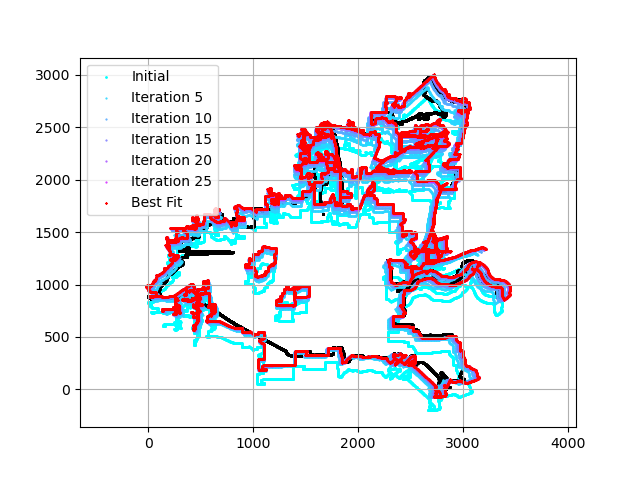


image 1/1 D:\RECTDNN\Uncompress\480296IND0_0985.jpg: 1696x1920 39 tiles, 324.7ms
Speed: 31.7ms preprocess, 324.7ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_0985.jpg: 1696x1920 1 county, 321.6ms
Speed: 25.4ms preprocess, 321.6ms inference, 8.4ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_0985.jpg: 1696x1920 1 legend, 334.5ms
Speed: 20.3ms preprocess, 334.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)


ICP Steps:   0%|          | 0/30 [00:00<?, ?it/s]

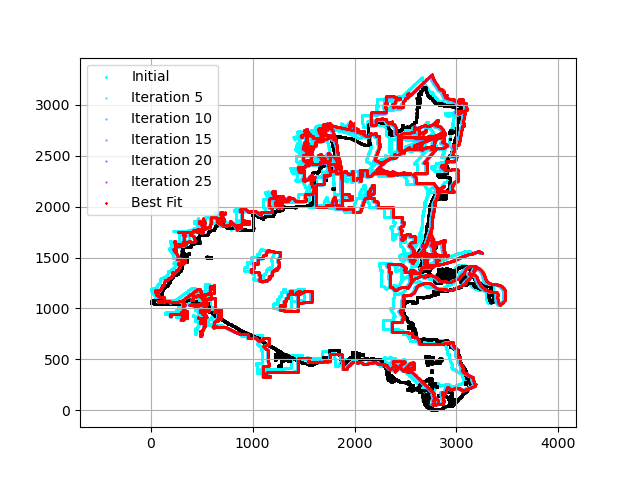


image 1/1 D:\RECTDNN\Uncompress\480296IND0_0987.jpg: 1696x1920 39 tiles, 332.9ms
Speed: 21.7ms preprocess, 332.9ms inference, 0.4ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_0987.jpg: 1696x1920 1 county, 329.1ms
Speed: 20.3ms preprocess, 329.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_0987.jpg: 1696x1920 1 legend, 325.5ms
Speed: 29.0ms preprocess, 325.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)


ICP Steps:   0%|          | 0/30 [00:00<?, ?it/s]

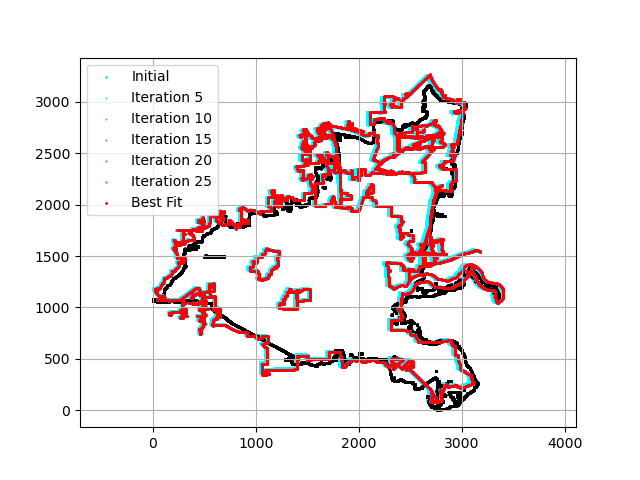


image 1/1 D:\RECTDNN\Uncompress\480296IND0_1279.jpg: 1696x1920 39 tiles, 327.4ms
Speed: 23.1ms preprocess, 327.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_1279.jpg: 1696x1920 2 countys, 333.5ms
Speed: 20.4ms preprocess, 333.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296IND0_1279.jpg: 1696x1920 1 legend, 320.0ms
Speed: 24.0ms preprocess, 320.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1696, 1920)


ICP Steps:   0%|          | 0/30 [00:00<?, ?it/s]

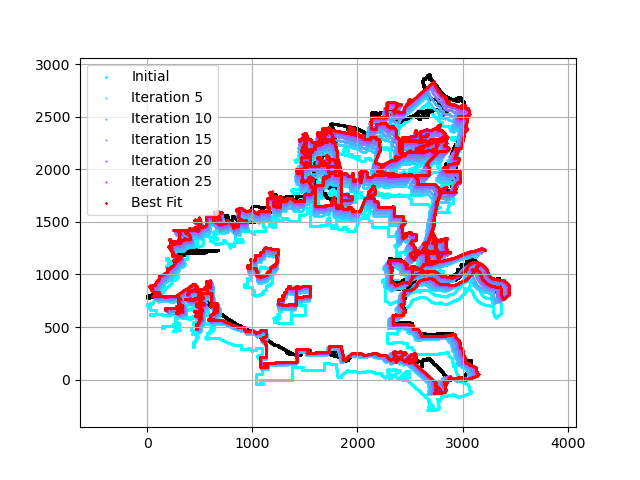


image 1/1 D:\RECTDNN\Uncompress\480296A_1.tif: 1248x1920 175 tiles, 242.5ms
Speed: 16.6ms preprocess, 242.5ms inference, 11.0ms postprocess per image at shape (1, 3, 1248, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296A_1.tif: 1248x1920 1 county, 241.1ms
Speed: 20.1ms preprocess, 241.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1248, 1920)

image 1/1 D:\RECTDNN\Uncompress\480296A_1.tif: 1248x1920 1 legend, 241.8ms
Speed: 20.2ms preprocess, 241.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1248, 1920)


ICP Steps:   0%|          | 0/30 [00:00<?, ?it/s]

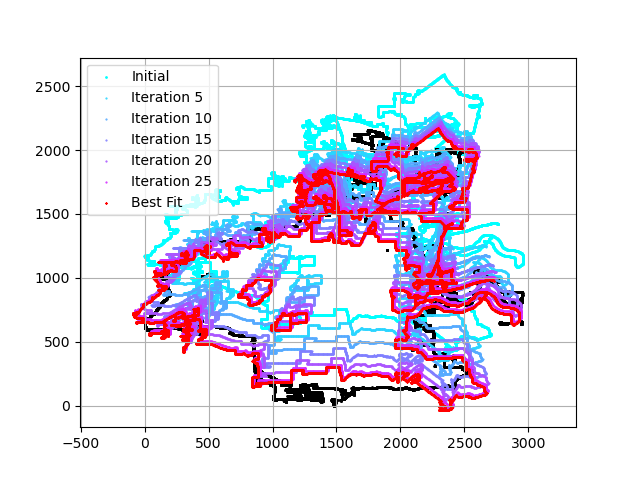

In [6]:
verbose = True

TPNN = None
RLNN = None
CLNN = None
TLNN = None

# THIS CHECKS WHETHER THE RUN WAS INTERRUPTED
# TO MAKE SURE WE'RE NOT STARTING FROM SCRATCH UNNECESSARILY
"""try:
    gen_dict
    print("Starting with predefined dict")
except:
    gen_dict = {}"""

gen_dict = {}

# OUTPUT DIRECTORY FOR GENERAL RESULTS STRUCTURE
output_struct_dir = os.path.join(outputs_dir, "IndexCoords.pkl")

if not os.path.exists(output_struct_dir):
    for i, row in tqdm(index_files.iterrows(), total=index_files.shape[0]):
        
        try:

            filename = os.path.basename(row["FilePath"])
            
            # THIS CHECKS WHETHER THIS PARTICULAR RASTER WAS RUN ALREADY BY USING THE INDIVIDUAL PKL FILE
            if os.path.exists(os.path.join(outputs_dir, f"{filename}.pkl")):
                print(f"Skipping, found {os.path.join(outputs_dir, filename + '.pkl')}")
                continue

            # READ FILES AND CONVERT TO GRAYSCALE
            image = cv2.imread(row["FilePath"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_arry = np.asarray(image)
            
            # SAVE IMAGE TO OUTPUT DIRECTORY
            output_image_fn = os.path.join(outputs_dir, filename.split(".")[0] + ".tif")
            copyfile(row["FilePath"], output_image_fn)

            # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
            output = getBoundaryPoints(row, distance=100) # TODO: THIS IS THE SAME AS OUR APPROX ACCURACY - MAYBE MAKE IT TIGHTER? 
            if output is None:
                print(f"COULD NOT FIND SHAPEFILE FOR {filename}")
                continue
            point_boundary_gdf, shp_bounds = output
            
            # RUN IMAGES THROUGH DNNs
            classifications, TPNN  = findKeypoints(image, model=TPNN, **dnn_params['TPNN'])
            effectiveArea, RLNN    = findSquares(image, model=RLNN, **dnn_params['RLNN'])
            countyArea, CLNN       = findCounty(image, model=CLNN, **dnn_params['CLNN'])
            tiles, TLNN            = runTLNN(row['FilePath'], outputs_dir, TLNN=TLNN)

            dnn_outputs = {
                "classifications"   : classifications,
                "effectiveArea"     : effectiveArea,
                "countyArea"    : countyArea,
                "tiles"         : tiles
            }
            
            # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
            # bounds_panels = tiles["county"]["bbox"]
            bounds_panels = find_bbox(dnn_outputs['countyArea'][:, :, 1])

            # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
            if point_boundary_gdf is None:
                continue

            # DEFINE BOUNDARY STRUCTU
            boundaries = {
                "point_boundary_gdf"    : point_boundary_gdf,
                "shp_bounds"            : shp_bounds,
                "bounds_panels"         : bounds_panels,
            }

            # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
            key = findKey(row["Basename"])    
            if key is None:
                print(f"Could not find key in {filename}")
            
            # DO ICP
            transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, rotation=False, shear=False, perspective=False, icp_iterations=30, proc_limit=500)

            # GET TRANSFORM FROM ICP TO CRS TRANSFORM
            output_transform, transform_dict = ICPtoCRSTransform(image_arry, transform_dict)

            # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
            output_affine = Affine(*output_transform.flatten()[:6])
            with rio.open(output_image_fn, 'w',
                driver='GTiff',
                height=image.shape[0], width=image.shape[1],
                count=1, dtype=image.dtype,
                crs=f'EPSG:3857',
                transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                    dst.write(image, 1)   

            tiles['transform_info'] = transform_dict
            tiles['output_transform'] = output_transform
            tiles['DNN_outputs'] = dnn_outputs
            gen_dict[filename] = tiles
            
            with open(os.path.join(outputs_dir, f"{filename}.pkl"), 'wb') as handle:
                pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except Exception: 
            print(f'Error with {os.path.basename(row["FilePath"])}')
            print(traceback.format_exc())
            continue
    
    # SAVE AS GENERAL OUTPUT
    # with open(os.path.join(outputs_dir, "IndexCoords.pkl"), 'wb') as handle:
    #    pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(output_struct_dir, 'rb') as f:
        gen_dict = pickle.load(f)

In [7]:
gen_dict['480296IND0_0982.jpg']

{'tile': {0: {'bbox': array([       1894,      1347.5,      2358.9,      1704.9]),
   'data': <PIL.Image.Image image mode=RGB size=465x357>,
   'text': '|\n\n/\n\nI\n\n. L@?{ 0060 B,\n\no\n',
   'keyed_text': None,
   'confidence': 0.9707916},
  1: {'bbox': array([     1896.1,        1702,      2361.6,      2059.6]),
   'data': <PIL.Image.Image image mode=RGB size=465x357>,
   'text': '@\n\n480296 0090 B\n\nG\n',
   'keyed_text': '4802960090',
   'confidence': 0.97017753},
  2: {'bbox': array([     2357.8,      1700.4,      2822.1,      2060.5]),
   'data': <PIL.Image.Image image mode=RGB size=465x360>,
   'text': ']\n\n480296 0095 C\n',
   'keyed_text': '4802960095',
   'confidence': 0.9691049},
  3: {'bbox': array([     2361.9,      2759.5,      2822.7,      3115.4]),
   'data': <PIL.Image.Image image mode=RGB size=461x356>,
   'text': 'R\n\n480296 (_3185 c\n\nR\n\nB\\\n\n%\n\n2,\n\nYy\n\n%\n',
   'keyed_text': '480296_3185',
   'confidence': 0.9687891},
  4: {'bbox': array([     282

In [8]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")
intersections = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/OSM_Roads/TexasRoads_filtered_strict_3857_nondupe_smaller.gpkg", engine='pyogrio', use_arrow=True)
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)
init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

Which tiles are we processing?

In [9]:
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['480287', '48201']
for w in wildcards:
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

Build tile database for detections in images

In [10]:
duplicate_db, non_dupped_dict, dupped_dict = buildDetectedDatabase(gen_dict)

print(len(non_dupped_dict), len(dupped_dict))  

detected_tiles = pd.DataFrame.from_dict(non_dupped_dict).T
detected_tiles['geometry'] = detected_tiles['coords'].apply(bbox_to_polygon)
detected_tiles_gdf = gpd.GeoDataFrame(detected_tiles)
detected_tiles_gdf = detected_tiles_gdf[['geometry']]

87 50


Supplement tile database with existing world files

In [11]:
fn = os.path.join(proc_dir, "WorldFileDatabase.feather")
if os.path.exists(fn):
    df = pd.read_pickle(fn)
else:
    df = buildWorldFileDatabase(base_input_path, duplicate_db, stateplanes)
    df.to_pickle(fn)

  0%|          | 0/178 [00:00<?, ?it/s]

NO EPSG 48029C0265G
NO EPSG 48029C0313F
NO EPSG 48029C0385G
NO EPSG 48029C0405G
NO EPSG 48029C0410G
NO EPSG 48029C0440G
NO EPSG 48029C0445G
NO EPSG 48029C0455F
NO EPSG 48029C0457F
NO EPSG 48029C0459F
NO EPSG 48029C0470F
NO EPSG 48029C0476F
NO EPSG 48029C0478F
NO EPSG 48029C0595F
NO EPSG 48029C0605F
NO EPSG 48029C0610F
NO EPSG 48029C0615F
NO EPSG 48029C0620F
NO EPSG 48029C0630G
NO EPSG 48029C0632G
NO EPSG 48029C0633G
NO EPSG 48029C0634G
NO EPSG 48029C0735F
NO EPSG 48029C0745F
NO EPSG 48029C0755F
NO EPSG 48029C0760F
NO EPSG 48029C0765F
NO EPSG 48071C0160E
NO EPSG 48071C0180E
NO EPSG 4812710001D
NO EPSG 4812710002D
NO EPSG 48157C0285L
NO EPSG 48157C0305L
NO EPSG 48201C0170L
NO EPSG 48201C0195L
NO EPSG 48201C0195M
NO EPSG 48201C0235L
NO EPSG 48201C0240L
NO EPSG 48201C0245L
NO EPSG 48201C0265L
NO EPSG 48201C0270L
NO EPSG 48201C0290L
NO EPSG 48201C0290M
NO EPSG 48201C0295L
NO EPSG 48201C0360L
NO EPSG 48201C0370L
NO EPSG 48201C0380L
NO EPSG 48201C0380M
NO EPSG 48201C0385L
NO EPSG 48201C0385M


Save both databases as shapefiles

In [12]:
# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

gdf.to_file(os.path.join(proc_dir, "WorldFiles.shp"))
detected_tiles_gdf.to_file(os.path.join(proc_dir, "Detected.shp"))

11/14/2024 13:49:48 - WARNING - fiona._env -   Normalized/laundered field name: 'county_polygon' to 'county_pol'
11/14/2024 13:49:48 - WARNING - fiona._env -   Normalized/laundered field name: 'geotransform' to 'geotransfo'


For each image we are processing, identify street corners

In [13]:
half_path = os.path.join(proc_dir, "half_size")
yolo_path = os.path.join(proc_dir, "street_corners")

os.makedirs(half_path, exist_ok=True)
os.makedirs(yolo_path, exist_ok=True)

streetcorner_out_fn = os.path.join(proc_dir, "streetcorners.pkl")

if not os.path.exists(streetcorner_out_fn):
    print("Processing images from scratch")

    # NEED TO MAKE THEM HALF RESOLUTION
    processing_images=[]
    for tile in tqdm(tiles):
        half_out_fn = os.path.join(half_path, os.path.basename(tile))
        processing_images.append(half_out_fn)
        if not os.path.exists(half_out_fn):
            a    = cv2.imread(tile)
            half = cv2.resize(a,  (0, 0), fx=0.5, fy=0.5)
            cv2.imwrite(half_out_fn, half)

    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt",
        confidence_threshold=0.3,
        device="cuda",  # or 'cuda:0'
    )
    
    result = predict(source=half_path, # source=processing_images[0], # source=half_path, 
                    detection_model=detection_model, 
                    verbose=2, 
                    project=yolo_path,
                    slice_height=256, 
                    slice_width=256, 
                    model_device="cuda", 
                    return_dict=True, 
                    export_pickle=True,
                    visual_hide_labels=True)

    def get_largest_subdirectory(base_dir):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
        largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
        return os.path.join(base_dir, largest_subdir)

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )
else:
    streetcorner_dict = pickle.load(open(streetcorner_out_fn, "rb"))

Processing images from scratch


  0%|          | 0/599 [00:00<?, ?it/s]

There are 599 listed files in folder: half_size/


Performing inference on images:   0%|          | 0/599 [00:00<?, ?it/s]

Performing prediction on 99 slices.


Performing inference on images:   0%|          | 1/599 [00:03<37:13,  3.73s/it]

Prediction time is: 3619.55 ms
Performing prediction on 126 slices.


Performing inference on images:   0%|          | 2/599 [00:07<37:33,  3.78s/it]

Prediction time is: 3667.48 ms
Performing prediction on 126 slices.


Performing inference on images:   1%|          | 3/599 [00:11<37:51,  3.81s/it]

Prediction time is: 3635.24 ms


Performing inference on images:   1%|          | 3/599 [00:11<37:51,  3.81s/it]

Performing prediction on 126 slices.


Performing inference on images:   1%|          | 4/599 [00:15<37:25,  3.77s/it]

Prediction time is: 3581.04 ms
Performing prediction on 81 slices.


Performing inference on images:   1%|          | 5/599 [00:17<32:32,  3.29s/it]

Prediction time is: 2339.66 ms
Performing prediction on 126 slices.


Performing inference on images:   1%|          | 6/599 [00:21<34:13,  3.46s/it]

Prediction time is: 3630.43 ms
Performing prediction on 140 slices.


Performing inference on images:   1%|          | 7/599 [00:25<37:04,  3.76s/it]

Prediction time is: 4162.38 ms


Performing inference on images:   1%|          | 7/599 [00:25<37:04,  3.76s/it]

Performing prediction on 126 slices.


Prediction time is: 3694.03 ms


Performing inference on images:   1%|▏         | 8/599 [00:29<37:24,  3.80s/it]

Performing prediction on 140 slices.


Performing inference on images:   2%|▏         | 9/599 [00:33<38:24,  3.91s/it]

Prediction time is: 3982.00 ms
Performing prediction on 126 slices.


Performing inference on images:   2%|▏         | 10/599 [00:37<37:46,  3.85s/it]

Prediction time is: 3576.42 ms
Performing prediction on 126 slices.


Performing inference on images:   2%|▏         | 11/599 [00:41<37:25,  3.82s/it]

Prediction time is: 3616.17 ms
Performing prediction on 126 slices.


Performing inference on images:   2%|▏         | 12/599 [00:45<38:07,  3.90s/it]

Prediction time is: 3840.11 ms


Performing inference on images:   2%|▏         | 12/599 [00:45<38:07,  3.90s/it]

Performing prediction on 126 slices.


Performing inference on images:   2%|▏         | 12/599 [00:49<38:07,  3.90s/it]

Prediction time is: 3878.57 ms


Performing inference on images:   2%|▏         | 13/599 [00:49<38:42,  3.96s/it]

Performing prediction on 126 slices.


Performing inference on images:   2%|▏         | 14/599 [00:53<38:55,  3.99s/it]

Prediction time is: 3834.52 ms


Performing inference on images:   2%|▏         | 14/599 [00:53<38:55,  3.99s/it]

Performing prediction on 126 slices.


Performing inference on images:   3%|▎         | 15/599 [00:57<38:15,  3.93s/it]

Prediction time is: 3632.28 ms
Performing prediction on 99 slices.


Performing inference on images:   3%|▎         | 16/599 [01:00<35:16,  3.63s/it]

Prediction time is: 2825.71 ms
Performing prediction on 140 slices.


Prediction time is: 4021.51 ms


Performing inference on images:   3%|▎         | 17/599 [01:04<36:50,  3.80s/it]

Performing prediction on 126 slices.


Performing inference on images:   3%|▎         | 18/599 [01:08<36:37,  3.78s/it]

Prediction time is: 3588.17 ms
Performing prediction on 126 slices.


Performing inference on images:   3%|▎         | 19/599 [01:11<36:37,  3.79s/it]

Prediction time is: 3643.83 ms
Performing prediction on 126 slices.


Performing inference on images:   3%|▎         | 20/599 [01:15<36:17,  3.76s/it]

Prediction time is: 3565.73 ms
Performing prediction on 63 slices.


Performing inference on images:   4%|▎         | 21/599 [01:17<30:56,  3.21s/it]

Prediction time is: 1857.40 ms
Performing prediction on 81 slices.


Performing inference on images:   4%|▎         | 22/599 [01:20<28:44,  2.99s/it]

Prediction time is: 2350.29 ms
Performing prediction on 63 slices.


Performing inference on images:   4%|▍         | 23/599 [01:21<25:36,  2.67s/it]

Prediction time is: 1838.76 ms
Performing prediction on 140 slices.


Performing inference on images:   4%|▍         | 24/599 [01:26<29:48,  3.11s/it]

Prediction time is: 3991.75 ms
Performing prediction on 140 slices.


Prediction time is: 4052.77 ms


Performing inference on images:   4%|▍         | 25/599 [01:30<33:00,  3.45s/it]

Performing prediction on 90 slices.


Performing inference on images:   4%|▍         | 26/599 [01:33<30:49,  3.23s/it]

Prediction time is: 2575.82 ms
Performing prediction on 90 slices.


Performing inference on images:   5%|▍         | 27/599 [01:35<29:22,  3.08s/it]

Prediction time is: 2607.42 ms
Performing prediction on 140 slices.


Performing inference on images:   5%|▍         | 28/599 [01:40<32:39,  3.43s/it]

Prediction time is: 4032.40 ms


Performing inference on images:   5%|▍         | 28/599 [01:40<32:39,  3.43s/it]

Performing prediction on 126 slices.


Performing inference on images:   5%|▍         | 28/599 [01:43<32:39,  3.43s/it]

Prediction time is: 3647.17 ms


Performing inference on images:   5%|▍         | 29/599 [01:43<34:02,  3.58s/it]

Performing prediction on 140 slices.


Performing inference on images:   5%|▌         | 30/599 [01:48<36:08,  3.81s/it]

Prediction time is: 4130.72 ms


Performing inference on images:   5%|▌         | 30/599 [01:48<36:08,  3.81s/it]

Performing prediction on 126 slices.


Performing inference on images:   5%|▌         | 30/599 [01:52<36:08,  3.81s/it]

Prediction time is: 3742.96 ms


Performing inference on images:   5%|▌         | 31/599 [01:52<36:41,  3.88s/it]

Performing prediction on 126 slices.


Performing inference on images:   5%|▌         | 31/599 [01:56<36:41,  3.88s/it]

Prediction time is: 4046.51 ms


Performing inference on images:   5%|▌         | 32/599 [01:56<37:58,  4.02s/it]

Performing prediction on 126 slices.


Performing inference on images:   5%|▌         | 32/599 [02:00<37:58,  4.02s/it]

Prediction time is: 4087.65 ms


Performing inference on images:   6%|▌         | 33/599 [02:01<38:55,  4.13s/it]

Performing prediction on 140 slices.


Performing inference on images:   6%|▌         | 33/599 [02:05<38:55,  4.13s/it]

Prediction time is: 4171.48 ms


Performing inference on images:   6%|▌         | 34/599 [02:05<39:41,  4.21s/it]

Performing prediction on 126 slices.


Prediction time is: 3774.64 ms


Performing inference on images:   6%|▌         | 35/599 [02:09<38:58,  4.15s/it]

Performing prediction on 126 slices.


Performing inference on images:   6%|▌         | 35/599 [02:13<38:58,  4.15s/it]

Prediction time is: 3963.57 ms


Performing inference on images:   6%|▌         | 36/599 [02:13<39:20,  4.19s/it]

Performing prediction on 126 slices.


Performing inference on images:   6%|▌         | 36/599 [02:17<39:20,  4.19s/it]

Prediction time is: 4016.55 ms


Performing inference on images:   6%|▌         | 37/599 [02:18<39:36,  4.23s/it]

Performing prediction on 126 slices.


Performing inference on images:   6%|▋         | 38/599 [02:22<38:48,  4.15s/it]

Prediction time is: 3737.07 ms


Performing inference on images:   6%|▋         | 38/599 [02:22<38:48,  4.15s/it]

Performing prediction on 126 slices.


Performing inference on images:   6%|▋         | 38/599 [02:26<38:48,  4.15s/it]

Prediction time is: 4105.18 ms


Performing inference on images:   7%|▋         | 39/599 [02:26<39:23,  4.22s/it]

Performing prediction on 126 slices.


Performing inference on images:   7%|▋         | 39/599 [02:30<39:23,  4.22s/it]

Prediction time is: 4087.53 ms


Performing inference on images:   7%|▋         | 40/599 [02:30<39:45,  4.27s/it]

Performing prediction on 126 slices.


Performing inference on images:   7%|▋         | 41/599 [02:34<38:34,  4.15s/it]

Prediction time is: 3709.37 ms
Performing prediction on 126 slices.


Performing inference on images:   7%|▋         | 41/599 [02:38<38:34,  4.15s/it]

Prediction time is: 4016.91 ms


Performing inference on images:   7%|▋         | 42/599 [02:38<38:51,  4.19s/it]

Performing prediction on 140 slices.


Performing inference on images:   7%|▋         | 42/599 [02:43<38:51,  4.19s/it]

Prediction time is: 4461.80 ms


Performing inference on images:   7%|▋         | 43/599 [02:43<40:17,  4.35s/it]

Performing prediction on 126 slices.


Performing inference on images:   7%|▋         | 43/599 [02:47<40:17,  4.35s/it]

Prediction time is: 3934.21 ms


Performing inference on images:   7%|▋         | 44/599 [02:47<39:44,  4.30s/it]

Performing prediction on 126 slices.


Performing inference on images:   8%|▊         | 45/599 [02:51<39:16,  4.25s/it]

Prediction time is: 3900.30 ms


Performing inference on images:   8%|▊         | 45/599 [02:52<39:16,  4.25s/it]

Performing prediction on 126 slices.


Performing inference on images:   8%|▊         | 46/599 [02:56<38:37,  4.19s/it]

Prediction time is: 3813.25 ms


Performing inference on images:   8%|▊         | 46/599 [02:56<38:37,  4.19s/it]

Performing prediction on 140 slices.


Performing inference on images:   8%|▊         | 47/599 [03:00<38:36,  4.20s/it]

Prediction time is: 4053.03 ms
Performing prediction on 126 slices.


Performing inference on images:   8%|▊         | 48/599 [03:04<37:26,  4.08s/it]

Prediction time is: 3645.24 ms
Performing prediction on 140 slices.


Performing inference on images:   8%|▊         | 49/599 [03:08<37:43,  4.12s/it]

Prediction time is: 4048.51 ms
Performing prediction on 126 slices.


Performing inference on images:   8%|▊         | 50/599 [03:12<36:44,  4.01s/it]

Prediction time is: 3631.35 ms
Performing prediction on 126 slices.


Performing inference on images:   8%|▊         | 50/599 [03:15<36:44,  4.01s/it]

Prediction time is: 3813.97 ms


Performing inference on images:   9%|▊         | 51/599 [03:16<36:48,  4.03s/it]

Performing prediction on 126 slices.


Performing inference on images:   9%|▊         | 52/599 [03:20<36:45,  4.03s/it]

Prediction time is: 3794.11 ms


Performing inference on images:   9%|▊         | 52/599 [03:20<36:45,  4.03s/it]

Performing prediction on 126 slices.


Performing inference on images:   9%|▉         | 53/599 [03:23<35:59,  3.95s/it]

Prediction time is: 3626.21 ms
Performing prediction on 140 slices.


Performing inference on images:   9%|▉         | 54/599 [03:28<36:25,  4.01s/it]

Prediction time is: 4001.95 ms
Performing prediction on 126 slices.


Performing inference on images:   9%|▉         | 55/599 [03:31<35:53,  3.96s/it]

Prediction time is: 3672.33 ms
Performing prediction on 126 slices.


Performing inference on images:   9%|▉         | 56/599 [03:35<35:24,  3.91s/it]

Prediction time is: 3644.25 ms
Performing prediction on 126 slices.


Performing inference on images:  10%|▉         | 57/599 [03:39<35:16,  3.90s/it]

Prediction time is: 3698.63 ms
Performing prediction on 63 slices.


Performing inference on images:  10%|▉         | 58/599 [03:41<29:41,  3.29s/it]

Prediction time is: 1797.89 ms
Performing prediction on 126 slices.


Performing inference on images:  10%|▉         | 59/599 [03:45<31:46,  3.53s/it]

Prediction time is: 3860.87 ms


Performing inference on images:  10%|▉         | 59/599 [03:45<31:46,  3.53s/it]

Performing prediction on 63 slices.


Performing inference on images:  10%|█         | 60/599 [03:47<27:18,  3.04s/it]

Prediction time is: 1810.16 ms
Performing prediction on 81 slices.


Performing inference on images:  10%|█         | 61/599 [03:50<25:59,  2.90s/it]

Prediction time is: 2431.20 ms
Performing prediction on 63 slices.


Performing inference on images:  10%|█         | 62/599 [03:51<23:16,  2.60s/it]

Prediction time is: 1820.04 ms
Performing prediction on 126 slices.


Performing inference on images:  11%|█         | 63/599 [03:55<26:45,  3.00s/it]

Prediction time is: 3719.04 ms


Performing inference on images:  11%|█         | 63/599 [03:55<26:45,  3.00s/it]

Performing prediction on 140 slices.


Performing inference on images:  11%|█         | 64/599 [04:00<30:24,  3.41s/it]

Prediction time is: 4166.60 ms


Performing inference on images:  11%|█         | 64/599 [04:00<30:24,  3.41s/it]

Performing prediction on 126 slices.


Prediction time is: 3745.24 ms


Performing inference on images:  11%|█         | 65/599 [04:04<31:44,  3.57s/it]

Performing prediction on 81 slices.


Performing inference on images:  11%|█         | 66/599 [04:06<28:51,  3.25s/it]

Prediction time is: 2378.07 ms
Performing prediction on 81 slices.


Performing inference on images:  11%|█         | 67/599 [04:09<26:56,  3.04s/it]

Prediction time is: 2417.94 ms
Performing prediction on 140 slices.


Performing inference on images:  11%|█▏        | 68/599 [04:13<31:07,  3.52s/it]

Prediction time is: 4393.03 ms


Performing inference on images:  11%|█▏        | 68/599 [04:13<31:07,  3.52s/it]

Performing prediction on 126 slices.


Performing inference on images:  12%|█▏        | 69/599 [04:18<32:57,  3.73s/it]

Prediction time is: 3988.07 ms


Performing inference on images:  12%|█▏        | 69/599 [04:18<32:57,  3.73s/it]

Performing prediction on 126 slices.


Performing inference on images:  12%|█▏        | 70/599 [04:22<33:40,  3.82s/it]

Prediction time is: 3820.70 ms


Performing inference on images:  12%|█▏        | 70/599 [04:22<33:40,  3.82s/it]

Performing prediction on 126 slices.


Prediction time is: 3853.15 ms


Performing inference on images:  12%|█▏        | 71/599 [04:26<34:13,  3.89s/it]

Performing prediction on 126 slices.


Prediction time is: 3706.25 ms


Performing inference on images:  12%|█▏        | 72/599 [04:30<34:10,  3.89s/it]

Performing prediction on 126 slices.


Performing inference on images:  12%|█▏        | 73/599 [04:34<34:15,  3.91s/it]

Prediction time is: 3782.92 ms
Performing prediction on 126 slices.


Performing inference on images:  12%|█▏        | 74/599 [04:37<33:33,  3.84s/it]

Prediction time is: 3559.75 ms
Performing prediction on 126 slices.


Performing inference on images:  13%|█▎        | 75/599 [04:41<33:14,  3.81s/it]

Prediction time is: 3588.72 ms
Performing prediction on 126 slices.


Performing inference on images:  13%|█▎        | 76/599 [04:45<33:19,  3.82s/it]

Prediction time is: 3689.24 ms
Performing prediction on 140 slices.


Prediction time is: 4155.22 ms


Performing inference on images:  13%|█▎        | 77/599 [04:49<34:34,  3.97s/it]

Performing prediction on 126 slices.


Performing inference on images:  13%|█▎        | 78/599 [04:53<34:10,  3.94s/it]

Prediction time is: 3681.98 ms
Performing prediction on 126 slices.


Performing inference on images:  13%|█▎        | 79/599 [04:57<33:54,  3.91s/it]

Prediction time is: 3711.01 ms
Performing prediction on 126 slices.


Performing inference on images:  13%|█▎        | 80/599 [05:01<33:59,  3.93s/it]

Prediction time is: 3775.76 ms


Performing inference on images:  13%|█▎        | 80/599 [05:01<33:59,  3.93s/it]

Performing prediction on 126 slices.


Performing inference on images:  14%|█▎        | 81/599 [05:05<34:08,  3.95s/it]

Prediction time is: 3808.94 ms


Performing inference on images:  14%|█▎        | 81/599 [05:05<34:08,  3.95s/it]

Performing prediction on 126 slices.


Performing inference on images:  14%|█▎        | 82/599 [05:09<33:34,  3.90s/it]

Prediction time is: 3627.13 ms
Performing prediction on 126 slices.


Performing inference on images:  14%|█▍        | 83/599 [05:12<33:27,  3.89s/it]

Prediction time is: 3709.96 ms
Performing prediction on 140 slices.


Performing inference on images:  14%|█▍        | 84/599 [05:17<34:46,  4.05s/it]

Prediction time is: 4182.67 ms


Performing inference on images:  14%|█▍        | 84/599 [05:17<34:46,  4.05s/it]

Performing prediction on 126 slices.


Performing inference on images:  14%|█▍        | 84/599 [05:21<34:46,  4.05s/it]

Prediction time is: 3792.67 ms


Performing inference on images:  14%|█▍        | 85/599 [05:21<34:41,  4.05s/it]

Performing prediction on 140 slices.


Performing inference on images:  14%|█▍        | 86/599 [05:25<34:37,  4.05s/it]

Prediction time is: 3942.85 ms
Performing prediction on 126 slices.


Performing inference on images:  14%|█▍        | 86/599 [05:29<34:37,  4.05s/it]

Prediction time is: 4045.45 ms


Performing inference on images:  15%|█▍        | 87/599 [05:29<35:14,  4.13s/it]

Performing prediction on 126 slices.


Performing inference on images:  15%|█▍        | 87/599 [05:33<35:14,  4.13s/it]

Prediction time is: 4049.51 ms


Performing inference on images:  15%|█▍        | 88/599 [05:34<35:39,  4.19s/it]

Performing prediction on 126 slices.


Prediction time is: 3744.28 ms


Performing inference on images:  15%|█▍        | 89/599 [05:38<34:57,  4.11s/it]

Performing prediction on 140 slices.


Performing inference on images:  15%|█▌        | 90/599 [05:42<35:40,  4.21s/it]

Prediction time is: 4186.02 ms


Performing inference on images:  15%|█▌        | 90/599 [05:42<35:40,  4.21s/it]

Performing prediction on 126 slices.


Performing inference on images:  15%|█▌        | 91/599 [05:46<34:30,  4.08s/it]

Prediction time is: 3630.33 ms
Performing prediction on 126 slices.


Performing inference on images:  15%|█▌        | 91/599 [05:50<34:30,  4.08s/it]

Prediction time is: 3811.20 ms


Performing inference on images:  15%|█▌        | 92/599 [05:50<34:26,  4.08s/it]

Performing prediction on 126 slices.


Prediction time is: 3716.35 ms


Performing inference on images:  16%|█▌        | 93/599 [05:54<33:55,  4.02s/it]

Performing prediction on 126 slices.


Performing inference on images:  16%|█▌        | 94/599 [05:58<33:35,  3.99s/it]

Prediction time is: 3707.68 ms


Performing inference on images:  16%|█▌        | 94/599 [05:58<33:35,  3.99s/it]

Performing prediction on 140 slices.


Performing inference on images:  16%|█▌        | 95/599 [06:02<34:17,  4.08s/it]

Prediction time is: 4124.99 ms
Performing prediction on 126 slices.


Performing inference on images:  16%|█▌        | 96/599 [06:06<33:31,  4.00s/it]

Prediction time is: 3654.08 ms
Performing prediction on 126 slices.


Performing inference on images:  16%|█▌        | 97/599 [06:09<32:52,  3.93s/it]

Prediction time is: 3635.93 ms
Performing prediction on 126 slices.


Performing inference on images:  16%|█▋        | 98/599 [06:13<32:12,  3.86s/it]

Prediction time is: 3574.63 ms
Performing prediction on 126 slices.


Performing inference on images:  17%|█▋        | 99/599 [06:17<31:50,  3.82s/it]

Prediction time is: 3616.22 ms
Performing prediction on 126 slices.


Performing inference on images:  17%|█▋        | 100/599 [06:21<31:40,  3.81s/it]

Prediction time is: 3641.86 ms
Performing prediction on 126 slices.


Performing inference on images:  17%|█▋        | 101/599 [06:24<31:24,  3.78s/it]

Prediction time is: 3609.51 ms
Performing prediction on 140 slices.


Performing inference on images:  17%|█▋        | 102/599 [06:29<32:25,  3.92s/it]

Prediction time is: 4051.29 ms
Performing prediction on 126 slices.


Performing inference on images:  17%|█▋        | 103/599 [06:32<31:53,  3.86s/it]

Prediction time is: 3600.70 ms
Performing prediction on 140 slices.


Performing inference on images:  17%|█▋        | 104/599 [06:37<32:34,  3.95s/it]

Prediction time is: 3997.86 ms
Performing prediction on 126 slices.


Performing inference on images:  18%|█▊        | 105/599 [06:40<32:02,  3.89s/it]

Prediction time is: 3622.07 ms
Performing prediction on 140 slices.


Performing inference on images:  18%|█▊        | 106/599 [06:44<32:29,  3.96s/it]

Prediction time is: 3978.80 ms
Performing prediction on 126 slices.


Performing inference on images:  18%|█▊        | 107/599 [06:48<31:54,  3.89s/it]

Prediction time is: 3613.71 ms
Performing prediction on 140 slices.


Performing inference on images:  18%|█▊        | 108/599 [06:52<32:16,  3.94s/it]

Prediction time is: 3954.26 ms
Performing prediction on 126 slices.


Performing inference on images:  18%|█▊        | 109/599 [06:56<31:45,  3.89s/it]

Prediction time is: 3618.99 ms
Performing prediction on 126 slices.


Performing inference on images:  18%|█▊        | 110/599 [07:00<31:24,  3.85s/it]

Prediction time is: 3610.27 ms
Performing prediction on 140 slices.


Performing inference on images:  19%|█▊        | 111/599 [07:04<32:06,  3.95s/it]

Prediction time is: 4037.93 ms
Performing prediction on 140 slices.


Performing inference on images:  19%|█▊        | 112/599 [07:08<32:24,  3.99s/it]

Prediction time is: 3968.64 ms
Performing prediction on 126 slices.


Performing inference on images:  19%|█▉        | 113/599 [07:12<31:37,  3.90s/it]

Prediction time is: 3590.49 ms
Performing prediction on 140 slices.


Performing inference on images:  19%|█▉        | 114/599 [07:16<32:06,  3.97s/it]

Prediction time is: 4003.68 ms
Performing prediction on 140 slices.


Performing inference on images:  19%|█▉        | 115/599 [07:20<32:34,  4.04s/it]

Prediction time is: 4049.19 ms
Performing prediction on 126 slices.


Performing inference on images:  19%|█▉        | 116/599 [07:24<31:50,  3.96s/it]

Prediction time is: 3617.91 ms
Performing prediction on 126 slices.


Performing inference on images:  20%|█▉        | 117/599 [07:28<31:28,  3.92s/it]

Prediction time is: 3674.84 ms
Performing prediction on 126 slices.


Performing inference on images:  20%|█▉        | 118/599 [07:31<30:57,  3.86s/it]

Prediction time is: 3597.23 ms
Performing prediction on 126 slices.


Prediction time is: 3660.43 ms


Performing inference on images:  20%|█▉        | 119/599 [07:35<30:48,  3.85s/it]

Performing prediction on 126 slices.


Performing inference on images:  20%|██        | 120/599 [07:39<30:35,  3.83s/it]

Prediction time is: 3630.35 ms
Performing prediction on 63 slices.


Performing inference on images:  20%|██        | 121/599 [07:41<25:54,  3.25s/it]

Prediction time is: 1831.54 ms
Performing prediction on 126 slices.


Performing inference on images:  20%|██        | 122/599 [07:45<26:51,  3.38s/it]

Prediction time is: 3560.91 ms
Performing prediction on 81 slices.


Performing inference on images:  21%|██        | 123/599 [07:47<24:39,  3.11s/it]

Prediction time is: 2372.95 ms
Performing prediction on 90 slices.


Performing inference on images:  21%|██        | 123/599 [07:50<24:39,  3.11s/it]

Prediction time is: 2580.22 ms


Performing inference on images:  21%|██        | 124/599 [07:50<23:59,  3.03s/it]

Performing prediction on 77 slices.


Performing inference on images:  21%|██        | 125/599 [07:52<22:22,  2.83s/it]

Prediction time is: 2272.23 ms
Performing prediction on 77 slices.


Performing inference on images:  21%|██        | 126/599 [07:55<21:04,  2.67s/it]

Prediction time is: 2225.64 ms
Performing prediction on 77 slices.


Performing inference on images:  21%|██        | 127/599 [07:57<20:10,  2.56s/it]

Prediction time is: 2229.87 ms
Performing prediction on 77 slices.


Performing inference on images:  21%|██▏       | 128/599 [07:59<19:33,  2.49s/it]

Prediction time is: 2233.74 ms
Performing prediction on 77 slices.


Performing inference on images:  22%|██▏       | 129/599 [08:01<19:06,  2.44s/it]

Prediction time is: 2240.55 ms
Performing prediction on 77 slices.


Performing inference on images:  22%|██▏       | 130/599 [08:04<18:36,  2.38s/it]

Prediction time is: 2178.87 ms
Performing prediction on 77 slices.


Performing inference on images:  22%|██▏       | 131/599 [08:06<18:21,  2.35s/it]

Prediction time is: 2215.79 ms
Performing prediction on 77 slices.


Performing inference on images:  22%|██▏       | 132/599 [08:08<18:09,  2.33s/it]

Prediction time is: 2199.70 ms
Performing prediction on 77 slices.


Performing inference on images:  22%|██▏       | 133/599 [08:11<18:13,  2.35s/it]

Prediction time is: 2298.45 ms
Performing prediction on 77 slices.


Performing inference on images:  22%|██▏       | 134/599 [08:13<18:04,  2.33s/it]

Prediction time is: 2226.77 ms
Performing prediction on 77 slices.


Performing inference on images:  23%|██▎       | 135/599 [08:15<18:04,  2.34s/it]

Prediction time is: 2265.65 ms
Performing prediction on 77 slices.


Performing inference on images:  23%|██▎       | 136/599 [08:18<17:49,  2.31s/it]

Prediction time is: 2186.17 ms
Performing prediction on 77 slices.


Performing inference on images:  23%|██▎       | 137/599 [08:20<17:50,  2.32s/it]

Prediction time is: 2257.45 ms
Performing prediction on 77 slices.


Performing inference on images:  23%|██▎       | 138/599 [08:22<17:56,  2.33s/it]

Prediction time is: 2281.01 ms
Performing prediction on 77 slices.


Performing inference on images:  23%|██▎       | 139/599 [08:25<17:58,  2.34s/it]

Prediction time is: 2274.71 ms
Performing prediction on 77 slices.


Performing inference on images:  23%|██▎       | 140/599 [08:27<17:44,  2.32s/it]

Prediction time is: 2184.65 ms
Performing prediction on 77 slices.


Performing inference on images:  24%|██▎       | 141/599 [08:29<17:42,  2.32s/it]

Prediction time is: 2243.46 ms
Performing prediction on 77 slices.


Performing inference on images:  24%|██▎       | 142/599 [08:32<17:39,  2.32s/it]

Prediction time is: 2230.42 ms
Performing prediction on 77 slices.


Performing inference on images:  24%|██▍       | 143/599 [08:34<17:30,  2.30s/it]

Prediction time is: 2207.44 ms
Performing prediction on 77 slices.


Performing inference on images:  24%|██▍       | 144/599 [08:36<17:20,  2.29s/it]

Prediction time is: 2183.79 ms
Performing prediction on 77 slices.


Performing inference on images:  24%|██▍       | 145/599 [08:38<17:21,  2.29s/it]

Prediction time is: 2243.55 ms
Performing prediction on 77 slices.


Performing inference on images:  24%|██▍       | 146/599 [08:41<17:19,  2.29s/it]

Prediction time is: 2211.46 ms
Performing prediction on 77 slices.


Performing inference on images:  25%|██▍       | 147/599 [08:43<17:13,  2.29s/it]

Prediction time is: 2206.17 ms
Performing prediction on 77 slices.


Performing inference on images:  25%|██▍       | 148/599 [08:45<17:21,  2.31s/it]

Prediction time is: 2255.13 ms
Performing prediction on 77 slices.


Performing inference on images:  25%|██▍       | 149/599 [08:48<17:31,  2.34s/it]

Prediction time is: 2311.79 ms
Performing prediction on 77 slices.


Performing inference on images:  25%|██▌       | 150/599 [08:50<17:40,  2.36s/it]

Prediction time is: 2281.86 ms
Performing prediction on 77 slices.


Performing inference on images:  25%|██▌       | 151/599 [08:52<17:27,  2.34s/it]

Prediction time is: 2223.32 ms
Performing prediction on 77 slices.


Performing inference on images:  25%|██▌       | 152/599 [08:55<17:17,  2.32s/it]

Prediction time is: 2208.77 ms
Performing prediction on 77 slices.


Performing inference on images:  26%|██▌       | 153/599 [08:57<17:15,  2.32s/it]

Prediction time is: 2247.06 ms
Performing prediction on 77 slices.


Performing inference on images:  26%|██▌       | 154/599 [08:59<17:06,  2.31s/it]

Prediction time is: 2200.19 ms
Performing prediction on 77 slices.


Performing inference on images:  26%|██▌       | 155/599 [09:02<17:05,  2.31s/it]

Prediction time is: 2224.94 ms
Performing prediction on 77 slices.


Performing inference on images:  26%|██▌       | 156/599 [09:04<17:00,  2.30s/it]

Prediction time is: 2199.28 ms
Performing prediction on 77 slices.


Performing inference on images:  26%|██▌       | 157/599 [09:06<17:06,  2.32s/it]

Prediction time is: 2272.29 ms
Performing prediction on 77 slices.


Performing inference on images:  26%|██▋       | 158/599 [09:08<16:56,  2.30s/it]

Prediction time is: 2196.41 ms
Performing prediction on 77 slices.


Performing inference on images:  27%|██▋       | 159/599 [09:11<17:11,  2.34s/it]

Prediction time is: 2344.45 ms
Performing prediction on 77 slices.


Performing inference on images:  27%|██▋       | 160/599 [09:13<17:14,  2.36s/it]

Prediction time is: 2292.62 ms
Performing prediction on 77 slices.


Performing inference on images:  27%|██▋       | 161/599 [09:16<17:23,  2.38s/it]

Prediction time is: 2336.41 ms
Performing prediction on 77 slices.


Performing inference on images:  27%|██▋       | 162/599 [09:18<17:12,  2.36s/it]

Prediction time is: 2236.36 ms
Performing prediction on 77 slices.


Performing inference on images:  27%|██▋       | 163/599 [09:20<16:59,  2.34s/it]

Prediction time is: 2209.08 ms
Performing prediction on 77 slices.


Performing inference on images:  27%|██▋       | 164/599 [09:23<16:52,  2.33s/it]

Prediction time is: 2234.63 ms
Performing prediction on 77 slices.


Performing inference on images:  28%|██▊       | 165/599 [09:25<16:51,  2.33s/it]

Prediction time is: 2250.58 ms
Performing prediction on 77 slices.


Performing inference on images:  28%|██▊       | 166/599 [09:27<16:43,  2.32s/it]

Prediction time is: 2212.86 ms
Performing prediction on 77 slices.


Performing inference on images:  28%|██▊       | 167/599 [09:30<16:42,  2.32s/it]

Prediction time is: 2255.16 ms
Performing prediction on 77 slices.


Performing inference on images:  28%|██▊       | 168/599 [09:32<16:39,  2.32s/it]

Prediction time is: 2242.51 ms
Performing prediction on 77 slices.


Performing inference on images:  28%|██▊       | 169/599 [09:34<16:29,  2.30s/it]

Prediction time is: 2198.39 ms
Performing prediction on 77 slices.


Performing inference on images:  28%|██▊       | 169/599 [09:36<16:29,  2.30s/it]

Prediction time is: 2293.55 ms


Performing inference on images:  28%|██▊       | 170/599 [09:37<18:01,  2.52s/it]

Performing prediction on 77 slices.


Performing inference on images:  29%|██▊       | 171/599 [09:40<17:40,  2.48s/it]

Prediction time is: 2279.08 ms
Performing prediction on 77 slices.


Performing inference on images:  29%|██▊       | 172/599 [09:42<17:32,  2.46s/it]

Prediction time is: 2329.30 ms
Performing prediction on 77 slices.


Performing inference on images:  29%|██▉       | 173/599 [09:44<17:26,  2.46s/it]

Prediction time is: 2339.19 ms
Performing prediction on 77 slices.


Performing inference on images:  29%|██▉       | 174/599 [09:47<17:03,  2.41s/it]

Prediction time is: 2205.15 ms
Performing prediction on 77 slices.


Performing inference on images:  29%|██▉       | 175/599 [09:49<16:52,  2.39s/it]

Prediction time is: 2248.91 ms
Performing prediction on 77 slices.


Performing inference on images:  29%|██▉       | 176/599 [09:51<16:50,  2.39s/it]

Prediction time is: 2304.40 ms
Performing prediction on 77 slices.


Performing inference on images:  30%|██▉       | 177/599 [09:54<16:31,  2.35s/it]

Prediction time is: 2200.46 ms
Performing prediction on 77 slices.


Performing inference on images:  30%|██▉       | 178/599 [09:56<16:18,  2.32s/it]

Prediction time is: 2199.76 ms
Performing prediction on 77 slices.


Performing inference on images:  30%|██▉       | 179/599 [09:58<16:15,  2.32s/it]

Prediction time is: 2247.96 ms
Performing prediction on 77 slices.


Performing inference on images:  30%|███       | 180/599 [10:01<16:04,  2.30s/it]

Prediction time is: 2182.42 ms
Performing prediction on 77 slices.


Performing inference on images:  30%|███       | 181/599 [10:03<16:02,  2.30s/it]

Prediction time is: 2236.60 ms
Performing prediction on 77 slices.


Performing inference on images:  30%|███       | 182/599 [10:05<15:57,  2.30s/it]

Prediction time is: 2188.83 ms
Performing prediction on 77 slices.


Performing inference on images:  31%|███       | 183/599 [10:08<16:05,  2.32s/it]

Prediction time is: 2293.12 ms
Performing prediction on 77 slices.


Performing inference on images:  31%|███       | 184/599 [10:10<16:04,  2.32s/it]

Prediction time is: 2221.39 ms
Performing prediction on 77 slices.


Performing inference on images:  31%|███       | 185/599 [10:12<16:11,  2.35s/it]

Prediction time is: 2317.30 ms
Performing prediction on 77 slices.


Performing inference on images:  31%|███       | 186/599 [10:15<16:00,  2.33s/it]

Prediction time is: 2203.77 ms
Performing prediction on 77 slices.


Performing inference on images:  31%|███       | 187/599 [10:17<15:54,  2.32s/it]

Prediction time is: 2228.80 ms
Performing prediction on 77 slices.


Performing inference on images:  31%|███▏      | 188/599 [10:19<15:48,  2.31s/it]

Prediction time is: 2214.91 ms
Performing prediction on 77 slices.


Performing inference on images:  32%|███▏      | 189/599 [10:21<15:43,  2.30s/it]

Prediction time is: 2217.42 ms
Performing prediction on 77 slices.


Performing inference on images:  32%|███▏      | 190/599 [10:24<15:56,  2.34s/it]

Prediction time is: 2318.31 ms
Performing prediction on 77 slices.


Performing inference on images:  32%|███▏      | 191/599 [10:26<15:46,  2.32s/it]

Prediction time is: 2211.47 ms
Performing prediction on 77 slices.


Performing inference on images:  32%|███▏      | 192/599 [10:29<15:55,  2.35s/it]

Prediction time is: 2298.78 ms
Performing prediction on 77 slices.


Performing inference on images:  32%|███▏      | 193/599 [10:31<15:52,  2.35s/it]

Prediction time is: 2248.83 ms
Performing prediction on 77 slices.


Performing inference on images:  32%|███▏      | 194/599 [10:33<15:44,  2.33s/it]

Prediction time is: 2234.44 ms
Performing prediction on 77 slices.


Performing inference on images:  33%|███▎      | 195/599 [10:35<15:33,  2.31s/it]

Prediction time is: 2197.32 ms
Performing prediction on 77 slices.


Performing inference on images:  33%|███▎      | 196/599 [10:38<15:29,  2.31s/it]

Prediction time is: 2229.46 ms
Performing prediction on 77 slices.


Performing inference on images:  33%|███▎      | 197/599 [10:40<15:32,  2.32s/it]

Prediction time is: 2270.83 ms
Performing prediction on 77 slices.


Performing inference on images:  33%|███▎      | 198/599 [10:42<15:23,  2.30s/it]

Prediction time is: 2197.24 ms
Performing prediction on 77 slices.


Performing inference on images:  33%|███▎      | 199/599 [10:45<15:20,  2.30s/it]

Prediction time is: 2230.87 ms
Performing prediction on 77 slices.


Performing inference on images:  33%|███▎      | 200/599 [10:47<15:17,  2.30s/it]

Prediction time is: 2197.71 ms
Performing prediction on 77 slices.


Performing inference on images:  34%|███▎      | 201/599 [10:49<15:12,  2.29s/it]

Prediction time is: 2200.60 ms
Performing prediction on 77 slices.


Performing inference on images:  34%|███▎      | 202/599 [10:51<15:07,  2.28s/it]

Prediction time is: 2196.66 ms
Performing prediction on 77 slices.


Performing inference on images:  34%|███▍      | 203/599 [10:54<15:03,  2.28s/it]

Prediction time is: 2215.52 ms
Performing prediction on 77 slices.


Performing inference on images:  34%|███▍      | 204/599 [10:56<15:12,  2.31s/it]

Prediction time is: 2285.46 ms
Performing prediction on 77 slices.


Performing inference on images:  34%|███▍      | 205/599 [10:58<15:06,  2.30s/it]

Prediction time is: 2206.79 ms
Performing prediction on 77 slices.


Performing inference on images:  34%|███▍      | 206/599 [11:01<14:58,  2.29s/it]

Prediction time is: 2179.05 ms
Performing prediction on 77 slices.


Performing inference on images:  35%|███▍      | 207/599 [11:03<14:55,  2.28s/it]

Prediction time is: 2218.93 ms
Performing prediction on 77 slices.


Performing inference on images:  35%|███▍      | 208/599 [11:05<14:52,  2.28s/it]

Prediction time is: 2209.33 ms
Performing prediction on 77 slices.


Performing inference on images:  35%|███▍      | 209/599 [11:08<14:49,  2.28s/it]

Prediction time is: 2217.44 ms
Performing prediction on 77 slices.


Performing inference on images:  35%|███▌      | 210/599 [11:10<14:49,  2.29s/it]

Prediction time is: 2232.02 ms
Performing prediction on 77 slices.


Performing inference on images:  35%|███▌      | 211/599 [11:12<14:50,  2.30s/it]

Prediction time is: 2237.18 ms
Performing prediction on 77 slices.


Performing inference on images:  35%|███▌      | 212/599 [11:14<14:44,  2.29s/it]

Prediction time is: 2184.41 ms
Performing prediction on 77 slices.


Performing inference on images:  36%|███▌      | 213/599 [11:17<14:45,  2.29s/it]

Prediction time is: 2242.26 ms
Performing prediction on 77 slices.


Performing inference on images:  36%|███▌      | 214/599 [11:19<14:36,  2.28s/it]

Prediction time is: 2177.72 ms
Performing prediction on 77 slices.


Performing inference on images:  36%|███▌      | 215/599 [11:21<14:32,  2.27s/it]

Prediction time is: 2197.33 ms
Performing prediction on 77 slices.


Performing inference on images:  36%|███▌      | 216/599 [11:24<14:36,  2.29s/it]

Prediction time is: 2242.91 ms
Performing prediction on 77 slices.


Performing inference on images:  36%|███▌      | 217/599 [11:26<14:43,  2.31s/it]

Prediction time is: 2279.22 ms
Performing prediction on 77 slices.


Performing inference on images:  36%|███▋      | 218/599 [11:28<14:32,  2.29s/it]

Prediction time is: 2181.51 ms
Performing prediction on 77 slices.


Performing inference on images:  37%|███▋      | 219/599 [11:30<14:34,  2.30s/it]

Prediction time is: 2247.49 ms
Performing prediction on 77 slices.


Performing inference on images:  37%|███▋      | 220/599 [11:33<14:28,  2.29s/it]

Prediction time is: 2194.42 ms


Performing inference on images:  37%|███▋      | 220/599 [11:33<14:28,  2.29s/it]

Performing prediction on 925 slices.


Performing inference on images:  37%|███▋      | 220/599 [11:59<14:28,  2.29s/it]

Prediction time is: 26195.84 ms


Performing inference on images:  37%|███▋      | 221/599 [12:00<1:00:53,  9.66s/it]

Performing prediction on 725 slices.


Performing inference on images:  37%|███▋      | 221/599 [12:20<1:00:53,  9.66s/it]

Prediction time is: 20555.09 ms


Performing inference on images:  37%|███▋      | 222/599 [12:21<1:22:23, 13.11s/it]

Performing prediction on 140 slices.


Performing inference on images:  37%|███▋      | 223/599 [12:25<1:05:29, 10.45s/it]

Prediction time is: 4054.30 ms


Performing inference on images:  37%|███▋      | 223/599 [12:25<1:05:29, 10.45s/it]

Performing prediction on 900 slices.


Performing inference on images:  37%|███▋      | 223/599 [12:51<1:05:29, 10.45s/it]

Prediction time is: 25627.82 ms


Performing inference on images:  37%|███▋      | 224/599 [12:52<1:35:23, 15.26s/it]

Performing prediction on 650 slices.


Performing inference on images:  37%|███▋      | 224/599 [13:10<1:35:23, 15.26s/it]

Prediction time is: 18354.98 ms


Performing inference on images:  38%|███▊      | 225/599 [13:11<1:41:47, 16.33s/it]

Performing prediction on 900 slices.


Performing inference on images:  38%|███▊      | 225/599 [13:36<1:41:47, 16.33s/it]

Prediction time is: 25520.71 ms


Performing inference on images:  38%|███▊      | 226/599 [13:37<2:00:01, 19.31s/it]

Performing prediction on 650 slices.


Performing inference on images:  38%|███▊      | 226/599 [13:55<2:00:01, 19.31s/it]

Prediction time is: 18375.16 ms


Performing inference on images:  38%|███▊      | 227/599 [13:56<1:58:50, 19.17s/it]

Performing prediction on 450 slices.


Performing inference on images:  38%|███▊      | 227/599 [14:08<1:58:50, 19.17s/it]

Prediction time is: 12713.59 ms


Performing inference on images:  38%|███▊      | 228/599 [14:09<1:47:13, 17.34s/it]

Performing prediction on 925 slices.


Performing inference on images:  38%|███▊      | 228/599 [14:35<1:47:13, 17.34s/it]

Prediction time is: 26339.41 ms


Performing inference on images:  38%|███▊      | 229/599 [14:36<2:04:53, 20.25s/it]

Performing prediction on 925 slices.


Performing inference on images:  38%|███▊      | 229/599 [15:02<2:04:53, 20.25s/it]

Prediction time is: 26326.86 ms


Performing inference on images:  38%|███▊      | 230/599 [15:03<2:17:14, 22.32s/it]

Performing prediction on 925 slices.


Performing inference on images:  38%|███▊      | 230/599 [15:30<2:17:14, 22.32s/it]

Prediction time is: 26648.98 ms


Performing inference on images:  39%|███▊      | 231/599 [15:30<2:26:41, 23.92s/it]

Performing prediction on 140 slices.


Performing inference on images:  39%|███▊      | 232/599 [15:35<1:50:27, 18.06s/it]

Prediction time is: 4156.42 ms


Performing inference on images:  39%|███▊      | 232/599 [15:35<1:50:27, 18.06s/it]

Performing prediction on 900 slices.


Performing inference on images:  39%|███▊      | 232/599 [16:01<1:50:27, 18.06s/it]

Prediction time is: 25898.70 ms


Performing inference on images:  39%|███▉      | 233/599 [16:02<2:06:03, 20.66s/it]

Performing prediction on 650 slices.


Performing inference on images:  39%|███▉      | 233/599 [16:20<2:06:03, 20.66s/it]

Prediction time is: 18341.33 ms


Performing inference on images:  39%|███▉      | 234/599 [16:20<2:02:17, 20.10s/it]

Performing prediction on 140 slices.


Performing inference on images:  39%|███▉      | 235/599 [16:25<1:33:36, 15.43s/it]

Prediction time is: 4289.58 ms


Performing inference on images:  39%|███▉      | 235/599 [16:25<1:33:36, 15.43s/it]

Performing prediction on 962 slices.


Performing inference on images:  39%|███▉      | 235/599 [16:53<1:33:36, 15.43s/it]

Prediction time is: 27763.27 ms


Performing inference on images:  39%|███▉      | 236/599 [16:54<1:57:20, 19.39s/it]

Performing prediction on 925 slices.


Performing inference on images:  39%|███▉      | 236/599 [17:20<1:57:20, 19.39s/it]

Prediction time is: 26423.35 ms


Performing inference on images:  40%|███▉      | 237/599 [17:21<2:11:03, 21.72s/it]

Performing prediction on 625 slices.


Performing inference on images:  40%|███▉      | 237/599 [17:38<2:11:03, 21.72s/it]

Prediction time is: 17700.82 ms


Performing inference on images:  40%|███▉      | 238/599 [17:39<2:04:18, 20.66s/it]

Performing prediction on 900 slices.


Performing inference on images:  40%|███▉      | 238/599 [18:05<2:04:18, 20.66s/it]

Prediction time is: 25687.78 ms


Performing inference on images:  40%|███▉      | 239/599 [18:06<2:14:43, 22.45s/it]

Performing prediction on 725 slices.


Performing inference on images:  40%|███▉      | 239/599 [18:26<2:14:43, 22.45s/it]

Prediction time is: 20489.01 ms


Performing inference on images:  40%|████      | 240/599 [18:27<2:11:50, 22.03s/it]

Performing prediction on 450 slices.


Performing inference on images:  40%|████      | 240/599 [18:39<2:11:50, 22.03s/it]

Prediction time is: 12720.13 ms


Performing inference on images:  40%|████      | 241/599 [18:40<1:55:27, 19.35s/it]

Performing prediction on 650 slices.


Performing inference on images:  40%|████      | 241/599 [18:58<1:55:27, 19.35s/it]

Prediction time is: 18385.77 ms


Performing inference on images:  40%|████      | 242/599 [18:59<1:54:49, 19.30s/it]

Performing prediction on 925 slices.


Performing inference on images:  40%|████      | 242/599 [19:25<1:54:49, 19.30s/it]

Prediction time is: 26324.13 ms


Performing inference on images:  41%|████      | 243/599 [19:26<2:08:35, 21.67s/it]

Performing prediction on 140 slices.


Performing inference on images:  41%|████      | 244/599 [19:30<1:37:39, 16.51s/it]

Prediction time is: 4214.05 ms


Performing inference on images:  41%|████      | 244/599 [19:31<1:37:39, 16.51s/it]

Performing prediction on 900 slices.


Performing inference on images:  41%|████      | 244/599 [19:57<1:37:39, 16.51s/it]

Prediction time is: 25942.74 ms


Performing inference on images:  41%|████      | 245/599 [19:57<1:55:38, 19.60s/it]

Performing prediction on 900 slices.


Performing inference on images:  41%|████      | 245/599 [20:24<1:55:38, 19.60s/it]

Prediction time is: 26442.32 ms


Performing inference on images:  41%|████      | 246/599 [20:25<2:09:08, 21.95s/it]

Performing prediction on 650 slices.


Performing inference on images:  41%|████      | 246/599 [20:43<2:09:08, 21.95s/it]

Prediction time is: 18353.76 ms


Performing inference on images:  41%|████      | 247/599 [20:44<2:03:14, 21.01s/it]

Performing prediction on 900 slices.


Performing inference on images:  41%|████      | 247/599 [21:10<2:03:14, 21.01s/it]

Prediction time is: 26102.29 ms


Performing inference on images:  41%|████▏     | 248/599 [21:11<2:13:25, 22.81s/it]

Performing prediction on 925 slices.


Performing inference on images:  41%|████▏     | 248/599 [21:37<2:13:25, 22.81s/it]

Prediction time is: 26631.65 ms


Performing inference on images:  42%|████▏     | 249/599 [21:38<2:21:15, 24.22s/it]

Performing prediction on 925 slices.


Performing inference on images:  42%|████▏     | 249/599 [22:05<2:21:15, 24.22s/it]

Prediction time is: 26572.33 ms


Performing inference on images:  42%|████▏     | 250/599 [22:06<2:26:49, 25.24s/it]

Performing prediction on 925 slices.


Performing inference on images:  42%|████▏     | 250/599 [22:32<2:26:49, 25.24s/it]

Prediction time is: 26521.29 ms


Performing inference on images:  42%|████▏     | 251/599 [22:33<2:30:29, 25.95s/it]

Performing prediction on 925 slices.


Performing inference on images:  42%|████▏     | 251/599 [23:00<2:30:29, 25.95s/it]

Prediction time is: 26285.34 ms


Performing inference on images:  42%|████▏     | 252/599 [23:01<2:32:14, 26.32s/it]

Performing prediction on 900 slices.


Performing inference on images:  42%|████▏     | 252/599 [23:26<2:32:14, 26.32s/it]

Prediction time is: 25583.93 ms


Performing inference on images:  42%|████▏     | 253/599 [23:27<2:32:15, 26.40s/it]

Performing prediction on 650 slices.


Performing inference on images:  42%|████▏     | 253/599 [23:45<2:32:15, 26.40s/it]

Prediction time is: 18370.11 ms


Performing inference on images:  42%|████▏     | 254/599 [23:46<2:18:46, 24.14s/it]

Performing prediction on 962 slices.


Performing inference on images:  42%|████▏     | 254/599 [24:13<2:18:46, 24.14s/it]

Prediction time is: 27345.00 ms


Performing inference on images:  43%|████▎     | 255/599 [24:14<2:25:36, 25.40s/it]

Performing prediction on 925 slices.


Performing inference on images:  43%|████▎     | 255/599 [24:41<2:25:36, 25.40s/it]

Prediction time is: 26654.59 ms


Performing inference on images:  43%|████▎     | 256/599 [24:42<2:29:05, 26.08s/it]

Performing prediction on 925 slices.


Performing inference on images:  43%|████▎     | 256/599 [25:09<2:29:05, 26.08s/it]

Prediction time is: 26948.37 ms


Performing inference on images:  43%|████▎     | 257/599 [25:10<2:32:15, 26.71s/it]

Performing prediction on 725 slices.


Performing inference on images:  43%|████▎     | 257/599 [25:31<2:32:15, 26.71s/it]

Prediction time is: 20525.11 ms


Performing inference on images:  43%|████▎     | 258/599 [25:31<2:22:09, 25.01s/it]

Performing prediction on 925 slices.


Performing inference on images:  43%|████▎     | 258/599 [25:58<2:22:09, 25.01s/it]

Prediction time is: 26966.89 ms


Performing inference on images:  43%|████▎     | 259/599 [25:59<2:26:49, 25.91s/it]

Performing prediction on 925 slices.


Performing inference on images:  43%|████▎     | 259/599 [26:26<2:26:49, 25.91s/it]

Prediction time is: 26527.80 ms


Performing inference on images:  43%|████▎     | 260/599 [26:27<2:29:01, 26.38s/it]

Performing prediction on 900 slices.


Performing inference on images:  43%|████▎     | 260/599 [26:53<2:29:01, 26.38s/it]

Prediction time is: 25780.84 ms


Performing inference on images:  44%|████▎     | 261/599 [26:53<2:29:15, 26.50s/it]

Performing prediction on 750 slices.


Performing inference on images:  44%|████▎     | 261/599 [27:15<2:29:15, 26.50s/it]

Prediction time is: 21248.57 ms


Performing inference on images:  44%|████▎     | 262/599 [27:15<2:20:52, 25.08s/it]

Performing prediction on 650 slices.


Performing inference on images:  44%|████▎     | 262/599 [27:34<2:20:52, 25.08s/it]

Prediction time is: 18369.31 ms


Performing inference on images:  44%|████▍     | 263/599 [27:34<2:10:13, 23.25s/it]

Performing prediction on 725 slices.


Performing inference on images:  44%|████▍     | 263/599 [27:55<2:10:13, 23.25s/it]

Prediction time is: 20493.68 ms


Performing inference on images:  44%|████▍     | 264/599 [27:55<2:06:10, 22.60s/it]

Performing prediction on 875 slices.


Performing inference on images:  44%|████▍     | 264/599 [28:20<2:06:10, 22.60s/it]

Prediction time is: 24729.68 ms


Performing inference on images:  44%|████▍     | 265/599 [28:21<2:10:24, 23.43s/it]

Performing prediction on 900 slices.


Performing inference on images:  44%|████▍     | 265/599 [28:47<2:10:24, 23.43s/it]

Prediction time is: 26226.61 ms


Performing inference on images:  44%|████▍     | 266/599 [28:48<2:16:08, 24.53s/it]

Performing prediction on 900 slices.


Performing inference on images:  44%|████▍     | 266/599 [29:14<2:16:08, 24.53s/it]

Prediction time is: 26270.96 ms


Performing inference on images:  45%|████▍     | 267/599 [29:15<2:20:13, 25.34s/it]

Performing prediction on 650 slices.


Performing inference on images:  45%|████▍     | 267/599 [29:33<2:20:13, 25.34s/it]

Prediction time is: 18369.86 ms


Performing inference on images:  45%|████▍     | 268/599 [29:34<2:09:06, 23.40s/it]

Performing prediction on 900 slices.


Performing inference on images:  45%|████▍     | 268/599 [30:01<2:09:06, 23.40s/it]

Prediction time is: 27163.44 ms


Performing inference on images:  45%|████▍     | 269/599 [30:02<2:16:40, 24.85s/it]

Performing prediction on 650 slices.


Performing inference on images:  45%|████▍     | 269/599 [30:20<2:16:40, 24.85s/it]

Prediction time is: 18354.23 ms


Performing inference on images:  45%|████▌     | 270/599 [30:21<2:06:41, 23.10s/it]

Performing prediction on 900 slices.


Performing inference on images:  45%|████▌     | 270/599 [30:48<2:06:41, 23.10s/it]

Prediction time is: 27036.36 ms


Performing inference on images:  45%|████▌     | 271/599 [30:49<2:14:35, 24.62s/it]

Performing prediction on 725 slices.


Performing inference on images:  45%|████▌     | 271/599 [31:10<2:14:35, 24.62s/it]

Prediction time is: 20572.34 ms


Performing inference on images:  45%|████▌     | 272/599 [31:11<2:09:16, 23.72s/it]

Performing prediction on 925 slices.


Performing inference on images:  45%|████▌     | 272/599 [31:37<2:09:16, 23.72s/it]

Prediction time is: 26534.69 ms


Performing inference on images:  46%|████▌     | 273/599 [31:38<2:14:59, 24.85s/it]

Performing prediction on 725 slices.


Performing inference on images:  46%|████▌     | 273/599 [31:59<2:14:59, 24.85s/it]

Prediction time is: 20570.49 ms


Performing inference on images:  46%|████▌     | 274/599 [32:00<2:08:39, 23.75s/it]

Performing prediction on 875 slices.


Performing inference on images:  46%|████▌     | 274/599 [32:24<2:08:39, 23.75s/it]

Prediction time is: 24750.57 ms


Performing inference on images:  46%|████▌     | 275/599 [32:26<2:11:47, 24.41s/it]

Performing prediction on 875 slices.


Performing inference on images:  46%|████▌     | 275/599 [32:51<2:11:47, 24.41s/it]

Prediction time is: 24996.79 ms


Performing inference on images:  46%|████▌     | 276/599 [32:51<2:13:28, 24.79s/it]

Performing prediction on 900 slices.


Performing inference on images:  46%|████▌     | 276/599 [33:17<2:13:28, 24.79s/it]

Prediction time is: 25820.90 ms


Performing inference on images:  46%|████▌     | 277/599 [33:18<2:16:26, 25.42s/it]

Performing prediction on 925 slices.


Performing inference on images:  46%|████▌     | 277/599 [33:45<2:16:26, 25.42s/it]

Prediction time is: 26553.64 ms


Performing inference on images:  46%|████▋     | 278/599 [33:46<2:19:13, 26.02s/it]

Performing prediction on 725 slices.


Performing inference on images:  46%|████▋     | 278/599 [34:06<2:19:13, 26.02s/it]

Prediction time is: 20569.59 ms


Performing inference on images:  47%|████▋     | 279/599 [34:07<2:10:55, 24.55s/it]

Performing prediction on 450 slices.


Performing inference on images:  47%|████▋     | 279/599 [34:19<2:10:55, 24.55s/it]

Prediction time is: 12688.35 ms


Performing inference on images:  47%|████▋     | 280/599 [34:20<1:52:12, 21.11s/it]

Performing prediction on 725 slices.


Performing inference on images:  47%|████▋     | 280/599 [34:40<1:52:12, 21.11s/it]

Prediction time is: 20700.59 ms


Performing inference on images:  47%|████▋     | 281/599 [34:41<1:52:08, 21.16s/it]

Performing prediction on 494 slices.


Performing inference on images:  47%|████▋     | 281/599 [34:55<1:52:08, 21.16s/it]

Prediction time is: 13991.43 ms


Performing inference on images:  47%|████▋     | 282/599 [34:55<1:41:06, 19.14s/it]

Performing prediction on 725 slices.


Performing inference on images:  47%|████▋     | 282/599 [35:16<1:41:06, 19.14s/it]

Prediction time is: 20513.69 ms


Performing inference on images:  47%|████▋     | 283/599 [35:17<1:43:58, 19.74s/it]

Performing prediction on 900 slices.


Performing inference on images:  47%|████▋     | 283/599 [35:42<1:43:58, 19.74s/it]

Prediction time is: 25784.16 ms


Performing inference on images:  47%|████▋     | 284/599 [35:43<1:54:33, 21.82s/it]

Performing prediction on 725 slices.


Performing inference on images:  47%|████▋     | 284/599 [36:04<1:54:33, 21.82s/it]

Prediction time is: 20528.17 ms


Performing inference on images:  48%|████▊     | 285/599 [36:05<1:53:14, 21.64s/it]

Performing prediction on 925 slices.


Performing inference on images:  48%|████▊     | 285/599 [36:31<1:53:14, 21.64s/it]

Prediction time is: 26532.88 ms


Performing inference on images:  48%|████▊     | 286/599 [36:32<2:02:31, 23.49s/it]

Performing prediction on 925 slices.


Performing inference on images:  48%|████▊     | 286/599 [37:01<2:02:31, 23.49s/it]

Prediction time is: 28252.92 ms


Performing inference on images:  48%|████▊     | 287/599 [37:02<2:11:26, 25.28s/it]

Performing prediction on 725 slices.


Performing inference on images:  48%|████▊     | 287/599 [37:22<2:11:26, 25.28s/it]

Prediction time is: 20686.89 ms


Performing inference on images:  48%|████▊     | 288/599 [37:23<2:04:51, 24.09s/it]

Performing prediction on 925 slices.


Performing inference on images:  48%|████▊     | 288/599 [37:52<2:04:51, 24.09s/it]

Prediction time is: 28650.02 ms


Performing inference on images:  48%|████▊     | 289/599 [37:53<2:13:11, 25.78s/it]

Performing prediction on 725 slices.


Performing inference on images:  48%|████▊     | 289/599 [38:13<2:13:11, 25.78s/it]

Prediction time is: 20679.30 ms


Performing inference on images:  48%|████▊     | 290/599 [38:14<2:05:50, 24.44s/it]

Performing prediction on 725 slices.


Performing inference on images:  48%|████▊     | 290/599 [38:35<2:05:50, 24.44s/it]

Prediction time is: 20603.09 ms


Performing inference on images:  49%|████▊     | 291/599 [38:35<2:00:29, 23.47s/it]

Performing prediction on 875 slices.


Performing inference on images:  49%|████▊     | 291/599 [39:00<2:00:29, 23.47s/it]

Prediction time is: 24809.79 ms


Performing inference on images:  49%|████▊     | 292/599 [39:01<2:03:20, 24.11s/it]

Performing prediction on 925 slices.


Performing inference on images:  49%|████▊     | 292/599 [39:31<2:03:20, 24.11s/it]

Prediction time is: 30227.50 ms


Performing inference on images:  49%|████▉     | 293/599 [39:32<2:14:19, 26.34s/it]

Performing prediction on 725 slices.


Performing inference on images:  49%|████▉     | 293/599 [39:53<2:14:19, 26.34s/it]

Prediction time is: 20714.12 ms


Performing inference on images:  49%|████▉     | 294/599 [39:54<2:06:12, 24.83s/it]

Performing prediction on 875 slices.


Performing inference on images:  49%|████▉     | 294/599 [40:19<2:06:12, 24.83s/it]

Prediction time is: 24900.53 ms


Performing inference on images:  49%|████▉     | 295/599 [40:19<2:07:00, 25.07s/it]

Performing prediction on 900 slices.


Performing inference on images:  49%|████▉     | 295/599 [40:46<2:07:00, 25.07s/it]

Prediction time is: 26354.45 ms


Performing inference on images:  49%|████▉     | 296/599 [40:47<2:09:56, 25.73s/it]

Performing prediction on 725 slices.


Performing inference on images:  49%|████▉     | 296/599 [41:08<2:09:56, 25.73s/it]

Prediction time is: 20939.94 ms


Performing inference on images:  50%|████▉     | 297/599 [41:08<2:03:19, 24.50s/it]

Performing prediction on 725 slices.


Performing inference on images:  50%|████▉     | 297/599 [41:29<2:03:19, 24.50s/it]

Prediction time is: 20880.42 ms


Performing inference on images:  50%|████▉     | 298/599 [41:30<1:58:27, 23.61s/it]

Performing prediction on 875 slices.


Performing inference on images:  50%|████▉     | 298/599 [41:55<1:58:27, 23.61s/it]

Prediction time is: 25091.60 ms


Performing inference on images:  50%|████▉     | 299/599 [41:56<2:01:29, 24.30s/it]

Performing prediction on 925 slices.


Performing inference on images:  50%|████▉     | 299/599 [42:23<2:01:29, 24.30s/it]

Prediction time is: 26978.92 ms


Performing inference on images:  50%|█████     | 300/599 [42:24<2:06:41, 25.42s/it]

Performing prediction on 900 slices.


Performing inference on images:  50%|█████     | 300/599 [42:50<2:06:41, 25.42s/it]

Prediction time is: 25835.82 ms


Performing inference on images:  50%|█████     | 301/599 [42:51<2:08:27, 25.87s/it]

Performing prediction on 725 slices.


Performing inference on images:  50%|█████     | 301/599 [43:11<2:08:27, 25.87s/it]

Prediction time is: 20591.37 ms


Performing inference on images:  50%|█████     | 302/599 [43:12<2:01:05, 24.46s/it]

Performing prediction on 725 slices.


Performing inference on images:  50%|█████     | 302/599 [43:32<2:01:05, 24.46s/it]

Prediction time is: 20617.25 ms


Performing inference on images:  51%|█████     | 303/599 [43:33<1:55:57, 23.51s/it]

Performing prediction on 725 slices.


Performing inference on images:  51%|█████     | 303/599 [43:54<1:55:57, 23.51s/it]

Prediction time is: 20557.19 ms


Performing inference on images:  51%|█████     | 304/599 [43:54<1:52:06, 22.80s/it]

Performing prediction on 126 slices.


Performing inference on images:  51%|█████     | 305/599 [43:58<1:23:51, 17.11s/it]

Prediction time is: 3665.34 ms


Performing inference on images:  51%|█████     | 305/599 [43:58<1:23:51, 17.11s/it]

Performing prediction on 900 slices.


Performing inference on images:  51%|█████     | 305/599 [44:24<1:23:51, 17.11s/it]

Prediction time is: 25547.86 ms


Performing inference on images:  51%|█████     | 306/599 [44:24<1:36:55, 19.85s/it]

Performing prediction on 725 slices.


Performing inference on images:  51%|█████     | 306/599 [44:45<1:36:55, 19.85s/it]

Prediction time is: 21045.44 ms


Performing inference on images:  51%|█████▏    | 307/599 [44:46<1:39:21, 20.42s/it]

Performing prediction on 875 slices.


Performing inference on images:  51%|█████▏    | 307/599 [45:11<1:39:21, 20.42s/it]

Prediction time is: 25120.64 ms


Performing inference on images:  51%|█████▏    | 308/599 [45:12<1:47:02, 22.07s/it]

Performing prediction on 900 slices.


Performing inference on images:  51%|█████▏    | 308/599 [45:38<1:47:02, 22.07s/it]

Prediction time is: 25880.62 ms


Performing inference on images:  52%|█████▏    | 309/599 [45:39<1:54:01, 23.59s/it]

Performing prediction on 725 slices.


Performing inference on images:  52%|█████▏    | 309/599 [46:00<1:54:01, 23.59s/it]

Prediction time is: 20817.64 ms


Performing inference on images:  52%|█████▏    | 310/599 [46:01<1:50:35, 22.96s/it]

Performing prediction on 875 slices.


Performing inference on images:  52%|█████▏    | 310/599 [46:25<1:50:35, 22.96s/it]

Prediction time is: 24864.18 ms


Performing inference on images:  52%|█████▏    | 311/599 [46:26<1:54:01, 23.75s/it]

Performing prediction on 126 slices.


Performing inference on images:  52%|█████▏    | 311/599 [46:30<1:54:01, 23.75s/it]

Prediction time is: 4151.24 ms


Performing inference on images:  52%|█████▏    | 312/599 [46:31<1:25:57, 17.97s/it]

Performing prediction on 925 slices.


Performing inference on images:  52%|█████▏    | 312/599 [46:58<1:25:57, 17.97s/it]

Prediction time is: 27583.81 ms


Performing inference on images:  52%|█████▏    | 313/599 [46:59<1:40:54, 21.17s/it]

Performing prediction on 900 slices.


Performing inference on images:  52%|█████▏    | 313/599 [47:27<1:40:54, 21.17s/it]

Prediction time is: 27910.74 ms


Performing inference on images:  52%|█████▏    | 314/599 [47:28<1:51:49, 23.54s/it]

Performing prediction on 725 slices.


Performing inference on images:  52%|█████▏    | 314/599 [47:49<1:51:49, 23.54s/it]

Prediction time is: 20472.21 ms


Performing inference on images:  53%|█████▎    | 315/599 [47:50<1:47:48, 22.78s/it]

Performing prediction on 925 slices.


Performing inference on images:  53%|█████▎    | 315/599 [48:21<1:47:48, 22.78s/it]

Prediction time is: 31105.89 ms


Performing inference on images:  53%|█████▎    | 316/599 [48:22<2:01:09, 25.69s/it]

Performing prediction on 130 slices.


Performing inference on images:  53%|█████▎    | 316/599 [48:26<2:01:09, 25.69s/it]

Prediction time is: 4429.31 ms


Performing inference on images:  53%|█████▎    | 317/599 [48:27<1:31:14, 19.41s/it]

Performing prediction on 900 slices.


Performing inference on images:  53%|█████▎    | 317/599 [48:54<1:31:14, 19.41s/it]

Prediction time is: 26857.08 ms


Performing inference on images:  53%|█████▎    | 318/599 [48:55<1:42:46, 21.94s/it]

Performing prediction on 725 slices.


Performing inference on images:  53%|█████▎    | 318/599 [49:15<1:42:46, 21.94s/it]

Prediction time is: 20726.12 ms


Performing inference on images:  53%|█████▎    | 319/599 [49:16<1:41:37, 21.78s/it]

Performing prediction on 875 slices.


Performing inference on images:  53%|█████▎    | 319/599 [49:41<1:41:37, 21.78s/it]

Prediction time is: 24801.59 ms


Performing inference on images:  53%|█████▎    | 320/599 [49:42<1:46:37, 22.93s/it]

Performing prediction on 875 slices.


Performing inference on images:  53%|█████▎    | 320/599 [50:06<1:46:37, 22.93s/it]

Prediction time is: 24969.63 ms


Performing inference on images:  54%|█████▎    | 321/599 [50:07<1:50:08, 23.77s/it]

Performing prediction on 900 slices.


Performing inference on images:  54%|█████▎    | 321/599 [50:33<1:50:08, 23.77s/it]

Prediction time is: 25941.82 ms


Performing inference on images:  54%|█████▍    | 322/599 [50:34<1:54:05, 24.71s/it]

Performing prediction on 725 slices.


Performing inference on images:  54%|█████▍    | 322/599 [50:55<1:54:05, 24.71s/it]

Prediction time is: 20602.64 ms


Performing inference on images:  54%|█████▍    | 323/599 [50:56<1:48:58, 23.69s/it]

Performing prediction on 925 slices.


Performing inference on images:  54%|█████▍    | 323/599 [51:22<1:48:58, 23.69s/it]

Prediction time is: 26534.31 ms


Performing inference on images:  54%|█████▍    | 324/599 [51:23<1:54:07, 24.90s/it]

Performing prediction on 725 slices.


Performing inference on images:  54%|█████▍    | 324/599 [51:44<1:54:07, 24.90s/it]

Prediction time is: 20641.25 ms


Performing inference on images:  54%|█████▍    | 325/599 [51:44<1:48:43, 23.81s/it]

Performing prediction on 725 slices.


Performing inference on images:  54%|█████▍    | 325/599 [52:05<1:48:43, 23.81s/it]

Prediction time is: 20542.05 ms


Performing inference on images:  54%|█████▍    | 326/599 [52:05<1:44:33, 22.98s/it]

Performing prediction on 725 slices.


Performing inference on images:  54%|█████▍    | 326/599 [52:26<1:44:33, 22.98s/it]

Prediction time is: 20497.27 ms


Performing inference on images:  55%|█████▍    | 327/599 [52:26<1:41:28, 22.39s/it]

Performing prediction on 99 slices.


Performing inference on images:  55%|█████▍    | 328/599 [52:29<1:14:51, 16.57s/it]

Prediction time is: 2882.05 ms


Performing inference on images:  55%|█████▍    | 328/599 [52:29<1:14:51, 16.57s/it]

Performing prediction on 725 slices.


Performing inference on images:  55%|█████▍    | 328/599 [52:54<1:14:51, 16.57s/it]

Prediction time is: 24901.11 ms


Performing inference on images:  55%|█████▍    | 329/599 [52:55<1:26:43, 19.27s/it]

Performing prediction on 725 slices.


Performing inference on images:  55%|█████▍    | 329/599 [53:18<1:26:43, 19.27s/it]

Prediction time is: 22490.88 ms


Performing inference on images:  55%|█████▌    | 330/599 [53:18<1:31:46, 20.47s/it]

Performing prediction on 126 slices.


Performing inference on images:  55%|█████▌    | 330/599 [53:22<1:31:46, 20.47s/it]

Prediction time is: 4206.21 ms


Performing inference on images:  55%|█████▌    | 331/599 [53:23<1:10:07, 15.70s/it]

Performing prediction on 925 slices.


Performing inference on images:  55%|█████▌    | 331/599 [53:51<1:10:07, 15.70s/it]

Prediction time is: 27836.20 ms


Performing inference on images:  55%|█████▌    | 332/599 [53:52<1:27:33, 19.67s/it]

Performing prediction on 725 slices.


Performing inference on images:  55%|█████▌    | 332/599 [54:13<1:27:33, 19.67s/it]

Prediction time is: 21108.74 ms


Performing inference on images:  56%|█████▌    | 333/599 [54:14<1:30:14, 20.35s/it]

Performing prediction on 725 slices.


Performing inference on images:  56%|█████▌    | 333/599 [54:34<1:30:14, 20.35s/it]

Prediction time is: 20624.78 ms


Performing inference on images:  56%|█████▌    | 334/599 [54:35<1:31:19, 20.68s/it]

Performing prediction on 900 slices.


Performing inference on images:  56%|█████▌    | 334/599 [55:02<1:31:19, 20.68s/it]

Prediction time is: 27146.22 ms


Performing inference on images:  56%|█████▌    | 335/599 [55:04<1:41:07, 22.98s/it]

Performing prediction on 725 slices.


Performing inference on images:  56%|█████▌    | 335/599 [55:25<1:41:07, 22.98s/it]

Prediction time is: 21531.15 ms


Performing inference on images:  56%|█████▌    | 336/599 [55:26<1:40:00, 22.81s/it]

Performing prediction on 725 slices.


Performing inference on images:  56%|█████▌    | 336/599 [55:37<43:32,  9.93s/it]  


KeyboardInterrupt: 

In [ ]:
'''FANN_prior = None
RLNN_prior = None
model = None

color=False

plot_params = {"labels" : False, }
YOLO_params = {
    "device"  : "cuda",     "find_text" : False, 
    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,
    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True
}

# IF WE'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT
if os.path.exists(f'{proc_dir}results.pkl'):
    print("FOUND DICTIONARY, LOADING")
    with open(f'{proc_dir}results.pkl', 'rb') as handle:
        results_struct = pickle.load(handle)
else:
    results_struct = {}

# LOOP FOR EACH TILE
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):
    
    # DEFINE WHERE GEOREFERENCED TILE IS SAVED
    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")
    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")

    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP
    if results_struct.get(tile, None):
        # print(f"Found in dict, skipping {tile}")
        continue

    # WHICH VERSION OF FANN ARE WE USING
    if color:
        # RUN AND SAVE PREPROCESSING FANN AND RLNN
        prepped_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_prepped.png")                      # FILE NAME
        prepped, FANN_prior, RLNN_prior, bounds = findStreetCorners_colorPrep(tile, FANN=FANN_prior, RLNN=RLNN_prior)   # RUN FANN_PRIOR AND RLNN
        Image.fromarray(prepped).save(prepped_fn) # SAVE

        # RUN FANN
        results, model, base = runYOLO_Text(prepped_fn, model=model, model_weights=f"{data_dir}FANN/YOLO/051624.pt", **YOLO_params)
        
    else:
        bounds = None

        # RUN FANN
        results, model, base = runYOLO_Text(tile, model=model, model_weights=f"{data_dir}FANN/YOLO/051624_bw.pt", **YOLO_params)

    results_struct[tile] = results
    
    '' IF YOU WANT TO SAVE DETAILED OUTPUT, THIS CODE WORKS, BUT IT'S HELLA SLOW AND BURDENSOME
    temp_dict = {"results" : results, "bounds" : bounds, "results_2" : base}
    results_struct[tile] = fin_fn
    if os.path.exists(fin_fn):
        os.remove(fin_fn)
    with open(fin_fn, 'wb') as handle:
        pickle.dump(temp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    ''

    
    # SAVE EVERY N ITERATIONS AND LAST
    if i % 60 == 0 or i == len(tiles) - 1:
        file_path = f'{proc_dir}results.pkl'
        if os.path.exists(file_path):
            os.remove(file_path)
        with open(file_path, 'wb') as handle:
            pickle.dump(results_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)
    '''

'FANN_prior = None\nRLNN_prior = None\nmodel = None\n\ncolor=False\n\nplot_params = {"labels" : False, }\nYOLO_params = {\n    "device"  : "cuda",     "find_text" : False, \n    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,\n    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True\n}\n\n# IF WE\'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT\nif os.path.exists(f\'{proc_dir}results.pkl\'):\n    print("FOUND DICTIONARY, LOADING")\n    with open(f\'{proc_dir}results.pkl\', \'rb\') as handle:\n        results_struct = pickle.load(handle)\nelse:\n    results_struct = {}\n\n# LOOP FOR EACH TILE\nfor i, tile in tqdm(enumerate(tiles), total=len(tiles)):\n    \n    # DEFINE WHERE GEOREFERENCED TILE IS SAVED\n    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")\n    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")\n\n    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP\n    if

54


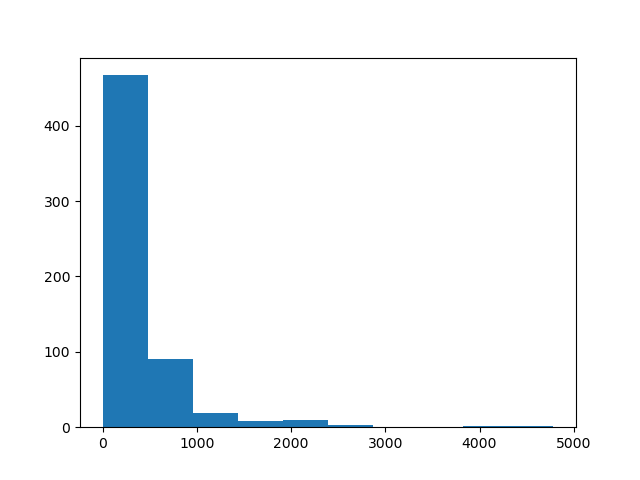

In [ ]:
plt.figure()
amount_of_corners = np.array([len(a) for a in streetcorner_dict.values()])
_ = plt.hist(amount_of_corners)
print(np.count_nonzero(amount_of_corners <= 10))

In [ ]:
def bboxTransformToCRS(transform, image):
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])
    
    translation = np.eye(3)
    translation[1, 2] = image.shape[0]

    return transform @ translation @ rev_y_axis


def bbox_to_coords_realworld(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_max, y_min, y_min, y_max]
    return xs, ys

def bbox_to_coords_raster(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_min, y_max, y_max, y_min]
    return xs, ys

bad = 0
RLNN = None

tile_coords = {}
debug_struct = {}

referencing_dir = os.path.join(proc_dir, "referencing")
os.makedirs(referencing_dir, exist_ok=True)

detected_tiles['reference_name'] = detected_tiles.index
list_tiles = list(detected_tiles_gdf.index)

# THERE'S AN ISSUE WITH PERFECT MATCHES ON SHORTER STRINGS. 
# (IE 48035 PERFECT FOR 48035001A, WHEN WE'RE LOOKING FOR 48035001)
# TO DEAL WITH IT, WE ONLY COMPARE AGAINST STRINGS OF A CERTAIN LENGTH 
# (SEE HEURISTICALLY-DETERMINED COMP_LENGTH BELOW)
# THIS STRUCTURE CONTAINS ALL POSSIBLE LENGTHS NEEDED, 
# SAVING APPROX 33% TIME INSTEAD OF DYNAMICALLY SHORTENING ALL STRINGS
curr_tile_name_length_dict = {}
bn_lengths = np.array([len(a) for a in tiles_bns])              # LENGTH OF BASENAMES FOR ALL TILES BEING USED
for i in range(np.min(bn_lengths) - 3, np.max(bn_lengths+3)):   # FOR A RANGE AROUND THAT BASE LENGTH
    curr_tile_name_length_dict[i] = [a if i <= len(a) else "" for a in list_tiles]

for i, tile in tqdm(enumerate(tiles), total=len(tiles)):

    comp_length = len(tiles_bns[i]) - 2

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", os.path.basename(tile))

    # PERFORM MATCHING
    match, score = process.extractOne(tiles_bns[i], curr_tile_name_length_dict[comp_length])
    matches = process.extract(tiles_bns[i], curr_tile_name_length_dict[comp_length])
    out_fn = os.path.join(referencing_dir, tiles_bns[i] + ".tif")
    
    if score >= 90:
        image = np.asarray(Image.open(tile))

        # IF IMAGE IS NOT UINT8, CONVERT
        if np.max(image) < 255:
            image = image * 255
            image = image.astype(np.uint8)

        tile_coords[out_fn] = detected_tiles.loc[match]
        tile_coords[out_fn]['input_file'] = tile

        bounds, RLNN = findBounds(tile, RLNN)
        
        if len(bounds[0]) < 1:
            print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile}")
            
            bbox = [0, 0, image.shape[0], image.shape[1]]
        else:
            bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        
        real_x, real_y = bbox_to_coords_realworld(tile_coords[out_fn]["coords"])
        pic_x, pic_y   = bbox_to_coords_raster(bbox)

        affine = affineTransformation(pic_x, pic_y, real_x, real_y)
        transform = bboxTransformToCRS(affine.matrix, image)

        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches, "bbox" : bbox,
            "real_x" : real_x, "real_y" : real_y,
            "pic_x"  : pic_x,  "pic_y"  : pic_y,
            "affine" : affine, "transform" : transform
        }
        try:
            with rio.open(out_fn, 'w',
                driver='GTiff', count=1, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
        except: 
            print(f"Could not save {tiles_bns[i]}")
                
    else:
        tile_coords[out_fn] = None
        print(f"Skipping {out_fn}")
        print(matches)
        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches,
        }
        bad = bad + 1

  0%|          | 0/599 [00:00<?, ?it/s]

Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_2.tif
[('480287_1', 82), ('4802870_1', 78), ('4802870', 75), ('4802870325', 74), ('4802870200', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_45.tif
[('4802870425', 80), ('4802870450', 80), ('4802870475', 80), ('4802870145', 80), ('4802870465', 80)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_25.tif
[('4802870325', 80), ('4802870425', 80), ('4802870525', 80), ('4802870250', 80), ('4802870225', 80)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_34.tif
[('4802870345', 80), ('4802870340', 80), ('48028703', 78), ('480287_1', 78), ('4802870_1', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_53.tif
[('4802870530', 80), ('48028703', 78), ('480287_1', 78), ('48028705360', 76), ('480287165', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_16.tif
[('480287_1', 89), ('480287165', 84),

  0%|          | 0/300 [00:00<?, ?it/s]

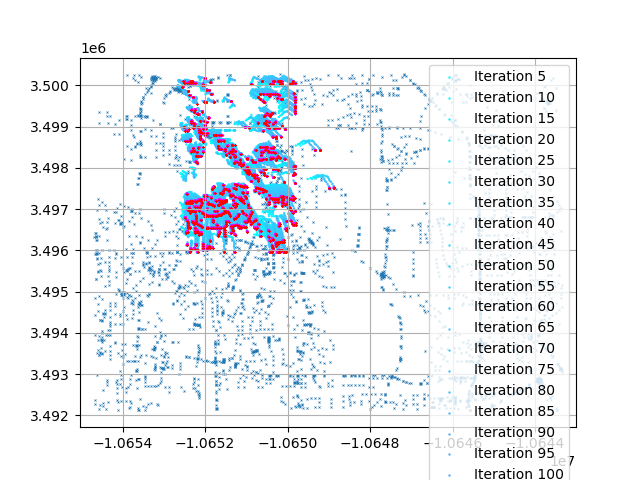

10/17/2024 16:55:43 - INFO - rasterio._env -   GDAL signalled an error: err_no=1, msg='Deleting D:/RECTDNN/processing/2024-10-11_15-08-46/48201C0420M_registered6.tif failed:\nPermission denied'


Could not save photo D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\48201C0420M.tif


  0%|          | 0/300 [00:00<?, ?it/s]

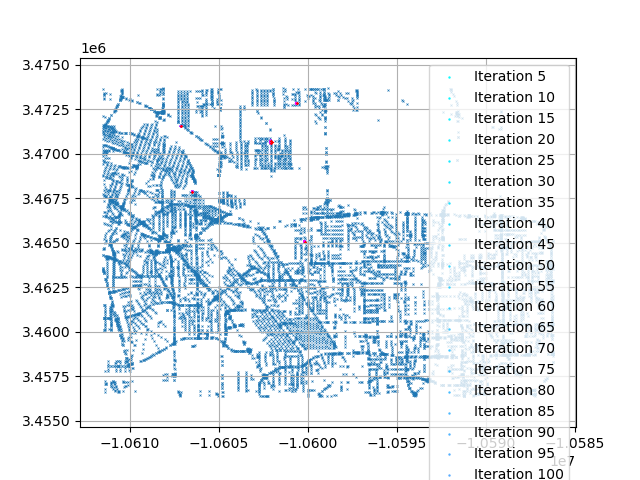

  0%|          | 0/300 [00:00<?, ?it/s]

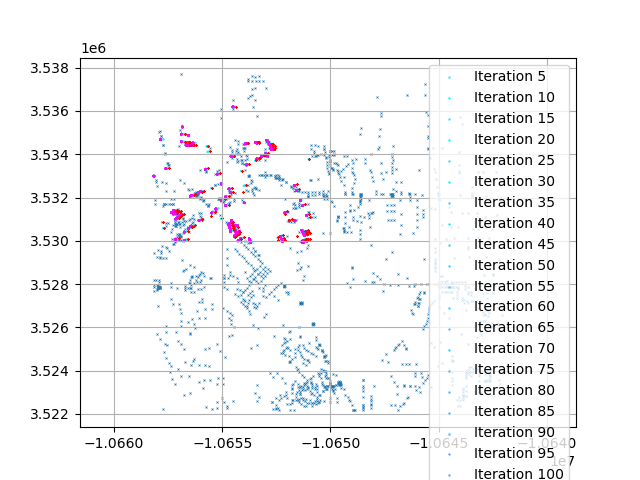

  0%|          | 0/300 [00:00<?, ?it/s]

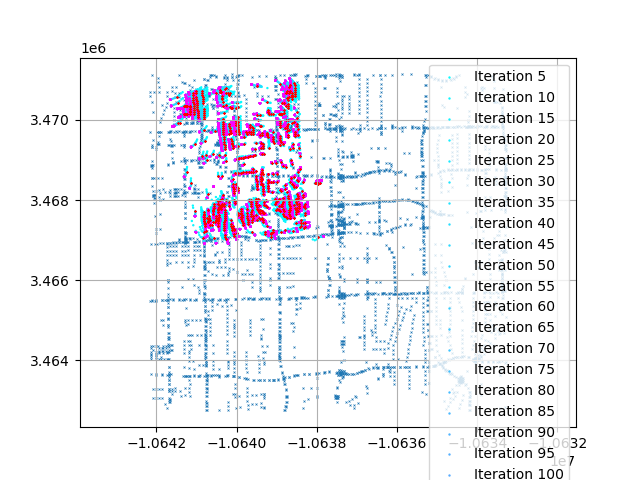

  0%|          | 0/300 [00:00<?, ?it/s]

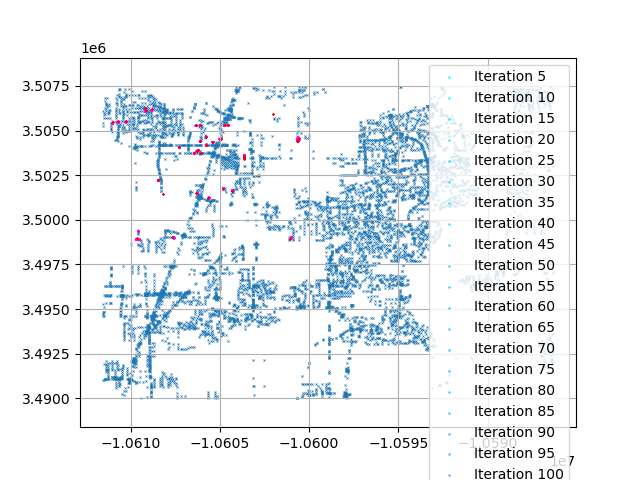

  0%|          | 0/300 [00:00<?, ?it/s]

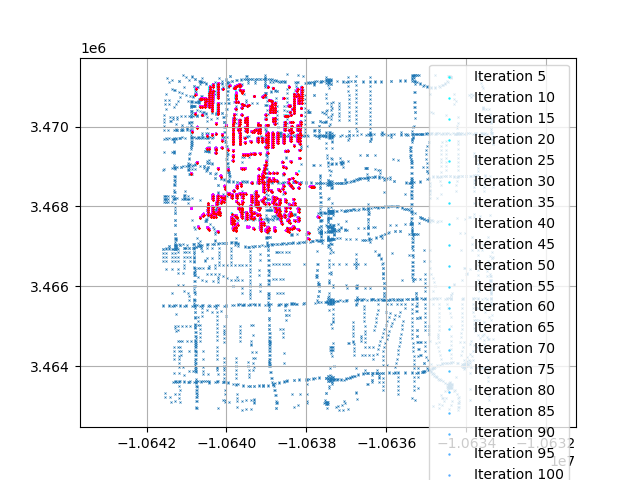

  0%|          | 0/300 [00:00<?, ?it/s]

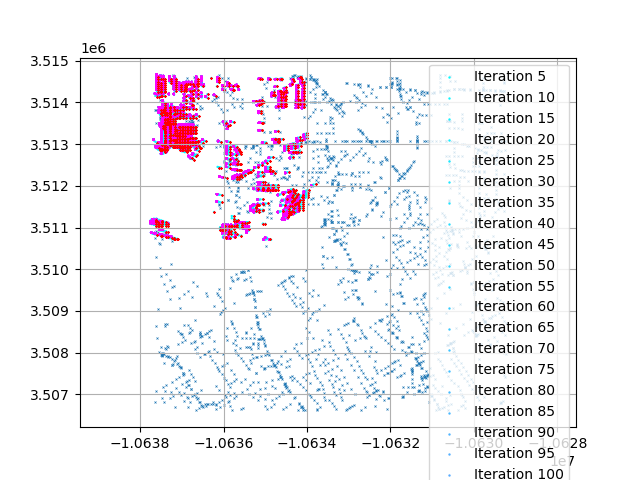

  0%|          | 0/300 [00:00<?, ?it/s]

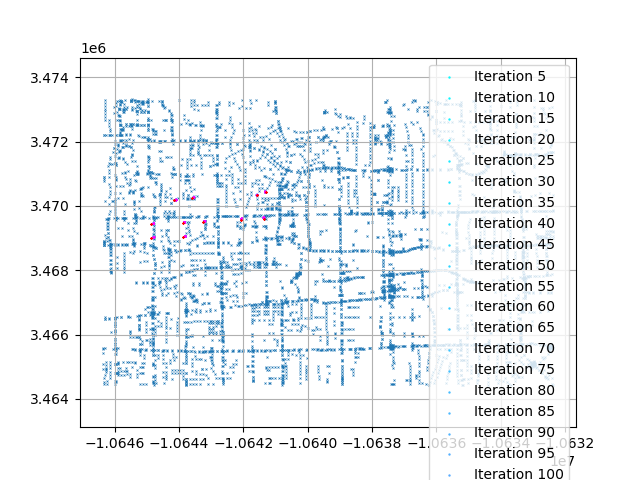

  0%|          | 0/300 [00:00<?, ?it/s]

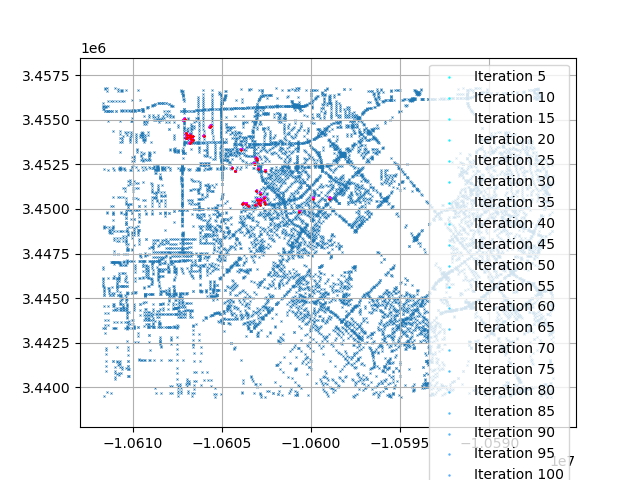

  0%|          | 0/300 [00:00<?, ?it/s]

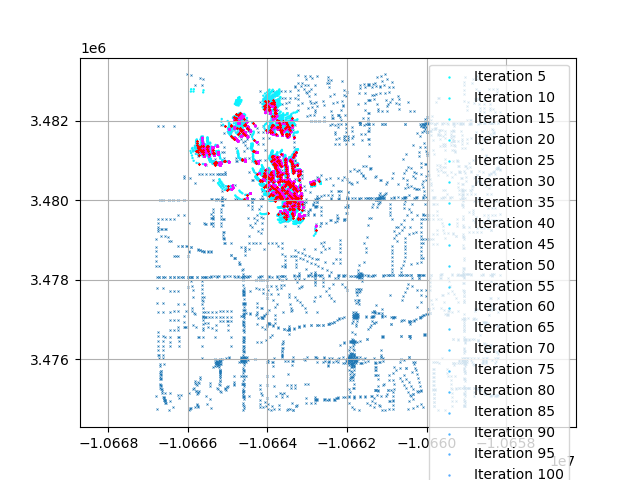

  0%|          | 0/300 [00:00<?, ?it/s]

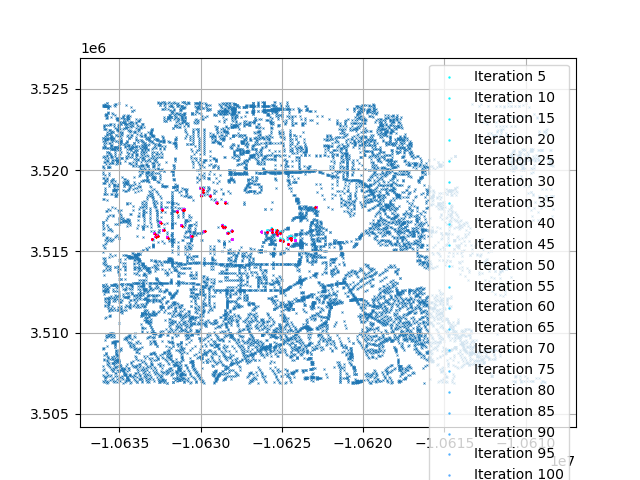

  0%|          | 0/300 [00:00<?, ?it/s]

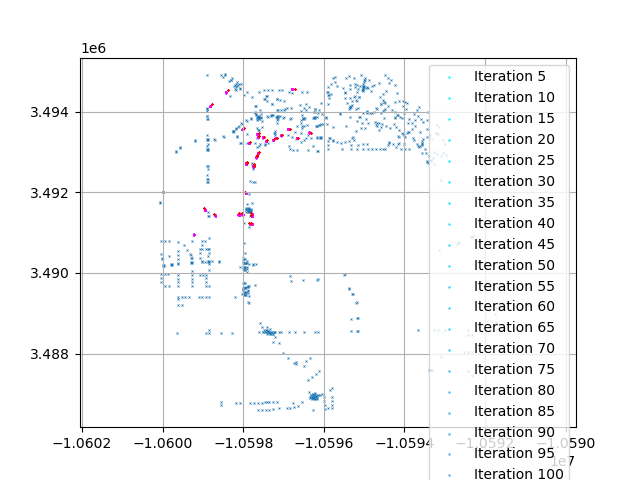

  0%|          | 0/300 [00:00<?, ?it/s]

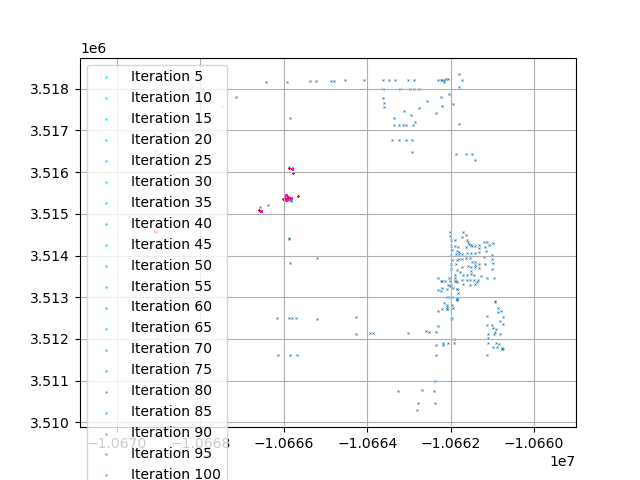

  0%|          | 0/300 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

In [ ]:
bestgrades = []
numcorners = []

allgrades = []

model = TPNN(num_classes=2, finalpadding=1, inputsize=2)
checkpoint = torch.load(r'C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/FANN/checkpoint_101123.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')

for i, (out_name, db) in enumerate(tile_coords.items()):
    if db is not None:

        # try:
        
            # OPEN RASTER AND GET BOUNDING BOX
            ra = rio.open(out_name)
            bounds  = ra.bounds
            image   = ra.read(1)

            # VALID BBOX FOR OBSERVATIONS OF ROADS
            bbox = debug_struct[out_name]['bbox']

            '''
            # RUN ROADS DETECTION ON CNN AND PREP FOR ICP
            roads, _    = split_and_run_cnn(image, model, tilesize=1024, num_dim=3, edges=10, dims_rep=[0], n_pyramids=2, device="cuda", verbose=True)
            roads_thin  = roads[:, :, 1] > 0.95
            roads_thin  = cleanImageBBOX(roads_thin, bbox)
            roads_thin  = skeletonize(roads_thin)    # USE SKELETONIZATION ALGORITHM TO THIN ROADS
            y, x        = np.where(roads_thin[:, :])            # GET X, Y COORDINATES OF IDENTIFIED ROAD POINTS
            street_det  = pointsToGeodataFrame(ra, y, x)        # CONVERT X, Y COORDINATES TO GDF AND REPROEJCT TO CURRENT ESTIMATE OF RASTER POSITION

            # USING CURRENT ENLARGED RASTER EXTENTS, GET RELEVANT ROADS FROM OPENSTREETMAP FILE
            bounds_poly = enlarged_bounds(ra, n=1)              # ENLARGED EXTENTS - NOTE, SET TO 1 (NO ENLARGEMENT) BECAUSE I'M NOT SURE HOW NEEDED THIS IS
            roads_clipped = gpd.clip(roads_gdf, bounds_poly)    # CLIP
            streets = getRoadPoints(roads_clipped, 0.5)         # ROAD POINTS ALONG STREETS, 0.5 IN M
            '''

            # RUN YOLO DETECTION ON STREET INTERSECTIONS AND PREP FOR DATASET
            # corner_bbox = [street_corners[a]['bbox'] for a in street_corners]
            # corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) 
            # GET STREET CORNERS FROM TPNN OUTPUTS
            corner_arry = streetcorner_dict[os.path.basename(out_name).split(".")[0] + ".pickle"]# streetresults_struct[tile_coords[out_name]['input_file']]
            corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
            corner_arry = cleanCenterBBOX(corner_arry, bbox)

            # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
            corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])
            
            # GET SHAPEFILE OF STREET INTERSECTIONS
            bounds_poly = enlarged_bounds(ra, n=1)              # ENLARGED EXTENTS - NOTE, SET TO 1 (NO ENLARGEMENT) BECAUSE I'M NOT SURE HOW NEEDED THIS IS
            corners = gpd.clip(intersections, bounds_poly)
            
            # DEFINE OUTPUT FILENAME
            ICP_fn = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_ICP.tif")
            
            # ACTUALLY PERFORM ICP AND SAVE OUTPUT GRADE
            # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, save_fig=ICP_fn, icp_iterations=500, conv=1e-6)
            # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, icp_iterations=50, conv=1e-6, rotation_limit=20)
            # out = performWeightedICPonTile([street_det, corner_gdf], [streets, corners], weights=[1, 1/50])
            # best_transform, transform_dict = performWeightedICPonTile([street_det, corner_gdf], [streets, corners],proc_limit=200, icp_iterations=90, plot_datasets=[roads_clipped, corners], weights=[1, 1/10], plot=False, shear=True )
            best_transform, transform_dict = performWeightedICPonTile([corner_gdf], [corners], proc_limit=5000, icp_iterations=300, plot_datasets=[corners], weights=[1, 1/10], plot=True, shear=True, dist_threshold=1000, )
            
            bestgrades.append(np.min(transform_dict['grades']))

            # SAVE WITH REGISTRATION
            raster_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_registered6.tif")
            transform = best_transform @ getMatrixFromAffine(ra.transform) 
            
            # SAVE POINTS USED FOR ESTIMATION
            shp_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_XY.gpkg")
            a = gpd.GeoDataFrame(crs="EPSG:3857", geometry=gpd.points_from_xy(transform_dict['reproj'][0][:, 0], transform_dict['reproj'][0][:, 1]))
            a.to_file(shp_name)

            # SAVE ANCILLARY FILES
            out_struct = {
                "best_transform" : best_transform,
                "transform_dict" : transform_dict,
            }

            allgrades.append(transform_dict)
            
            try:
                with rio.open(raster_name, 'w',
                    driver='GTiff', count=1, dtype=np.uint8,
                    height=image.shape[0], width=image.shape[1],
                    crs=f'EPSG:3857',
                    transform=rio.Affine(*transform.flatten()[:6])) as dst:
                        dst.write(image, 1) 
                        # dst.write(roads_thin * 255, 2) 
                        # dst.write(draw_bounding_boxes(corner_bbox, image.shape[:2]), 3) 

                with open(raster_name[:-4] + ".pkl", 'wb') as handle:
                    pickle.dump(out_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)

            except:
                print(f"Could not save photo {out_name}")
        #except:
        #    print(f"Error with {out_name}")
        #    continue

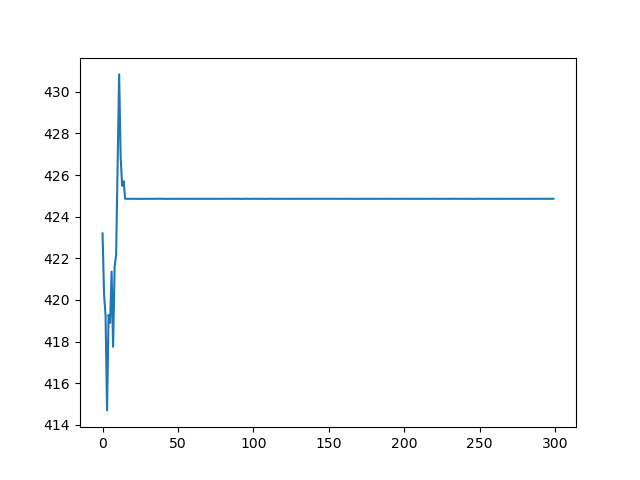

In [ ]:
plt.figure()
plt.plot(out_struct['transform_dict']['grades'])

In [ ]:
image.dtype

dtype('uint8')

In [ ]:
out_name

'D:\\RECTDNN\\processing\\2024-10-11_15-08-46\\\\referencing\\48201C0420M.tif'

In [ ]:
corner_arry.shape

(732, 2)